In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids, get_population
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final_runs/nih_us_cvd/2023_12_28_13_42_46/count_data

binned_ldl_exposure_time.csv  state_person_time.csv  ylls.csv
binned_sbp_exposure_time.csv  transition_count.csv
deaths.csv                    ylds.csv


In [3]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final_runs/nih_us_cvd/2023_12_28_13_42_46/count_data/'

# Investigate the Population Structure: 
1. Could the population just be decreasing? If so, would looking at rates change anything?
2. Could the population structure be changing (e.g., more people under 50 or over 70?)? If so, how would that affect outcomes? 

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv').reset_index(drop=True)
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index(drop=True) 
person_time = person_time.loc[person_time['scenario'] == 'baseline'].reset_index(drop=True) 
#person_time = person_time.loc[person_time['year'] != 2021].reset_index(drop=True) 
person_time.head()

Unnamed: 0     sex  year            measure  input_draw  scenario  \
0           0  Female  2021  state_person_time          29  baseline   
1           1  Female  2021  state_person_time          29  baseline   
2           2  Female  2021  state_person_time          29  baseline   
3           3  Female  2021  state_person_time          29  baseline   
4           4  Female  2021  state_person_time          29  baseline   

     location       age                  state     value  
0     alabama  25_to_29  acute_ischemic_stroke  0.000000  
1      alaska  25_to_29  acute_ischemic_stroke  0.076660  
2     arizona  25_to_29  acute_ischemic_stroke  0.229979  
3    arkansas  25_to_29  acute_ischemic_stroke  0.229979  
4  california  25_to_29  acute_ischemic_stroke  0.229979

In [5]:
all_person_time = person_time.groupby(['sex','year','input_draw','location']).value.sum().reset_index()
all_person_time_summ = all_person_time.groupby(['sex','year','location']).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
all_person_time_summ.head()

sex  year    location          mean          2.5%         97.5%
0  Female  2021     alabama  40939.840657  40798.129227  41193.370021
1  Female  2021      alaska  36224.671321  36099.625736  36498.640110
2  Female  2021     arizona  39745.817933  39558.104860  40064.345243
3  Female  2021    arkansas  39858.147570  39663.676934  40167.105818
4  Female  2021  california  39853.034360  39691.600274  40128.873648

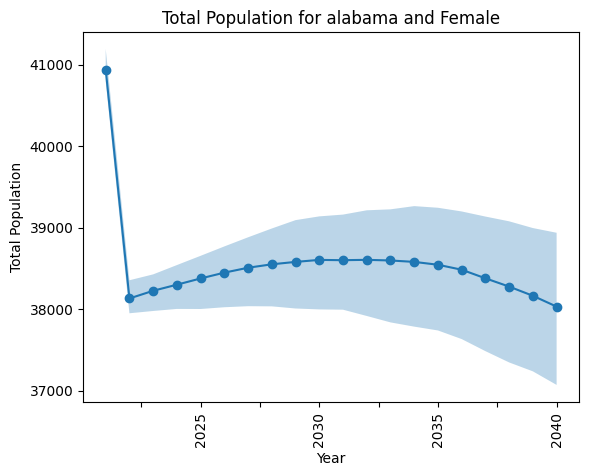

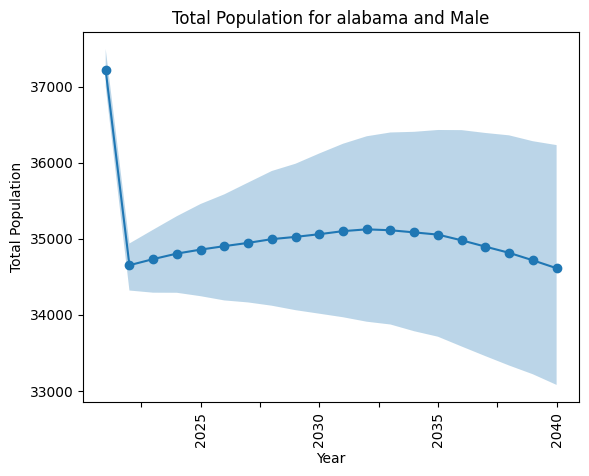

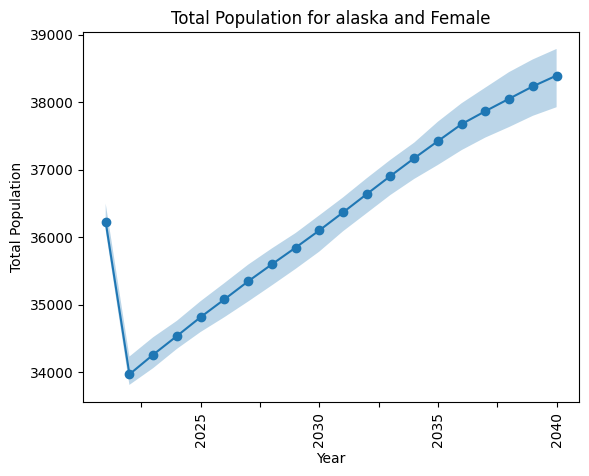

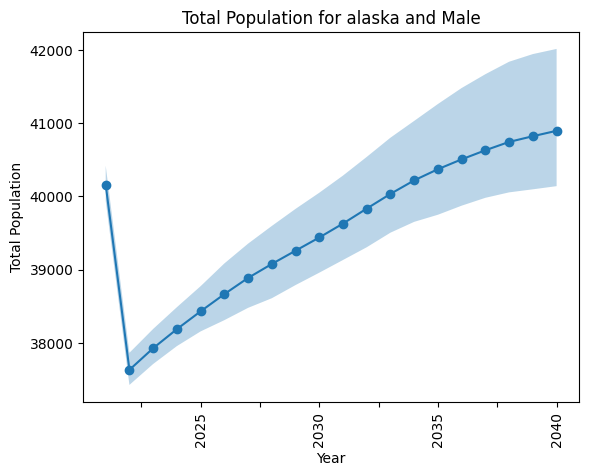

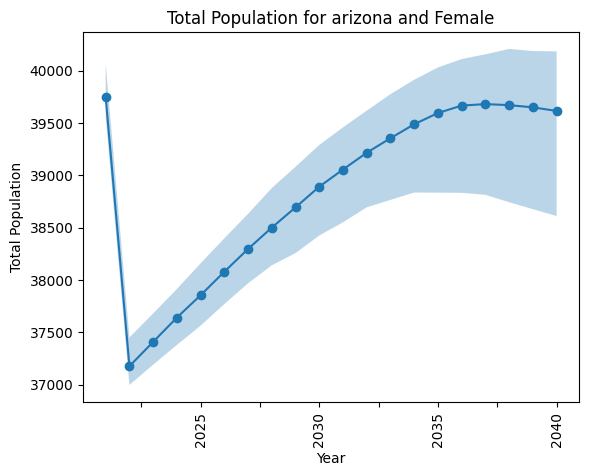

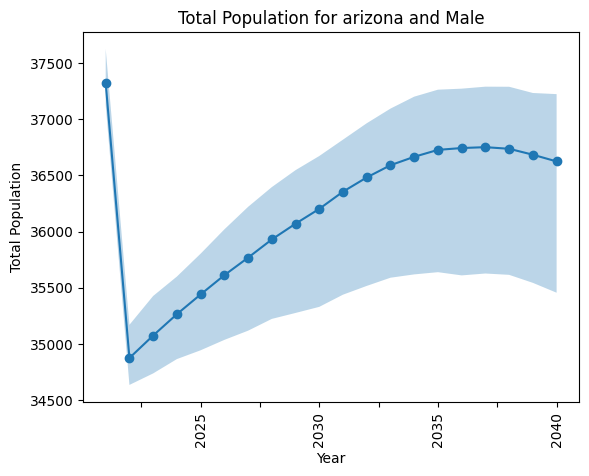

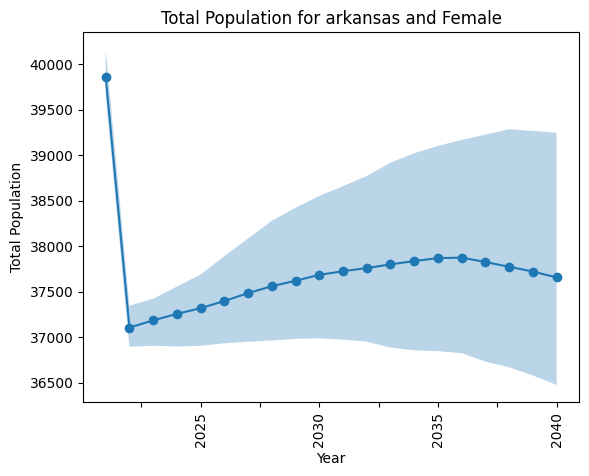

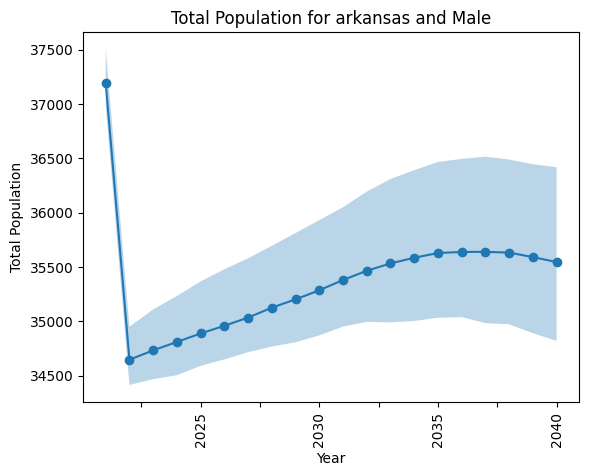

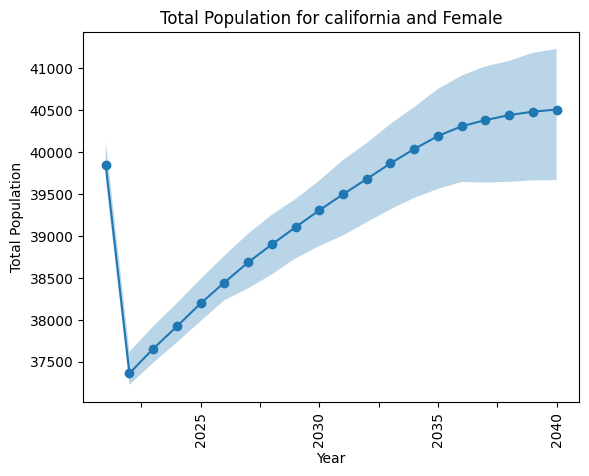

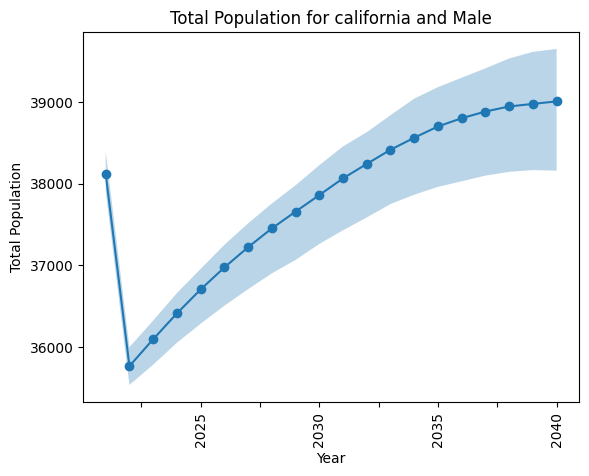

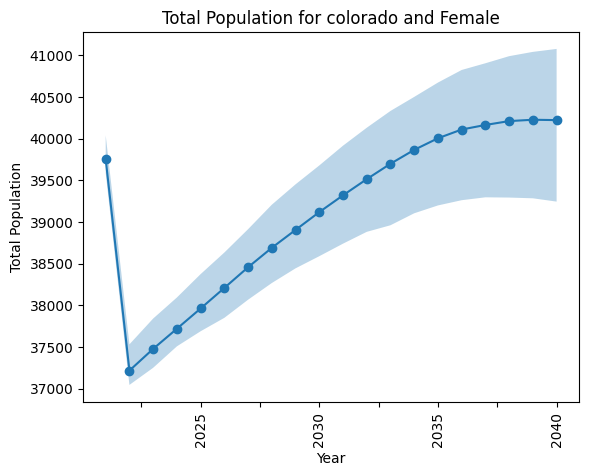

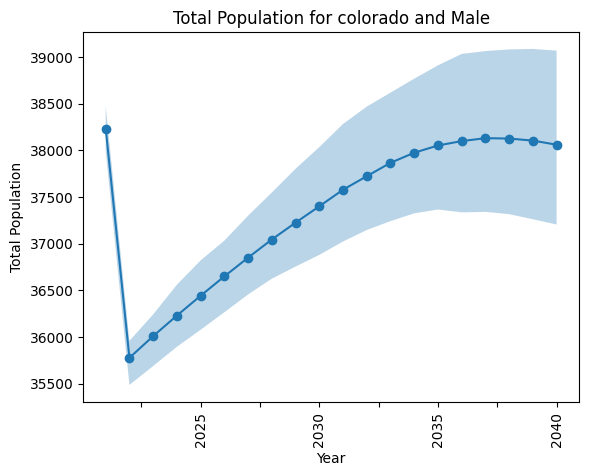

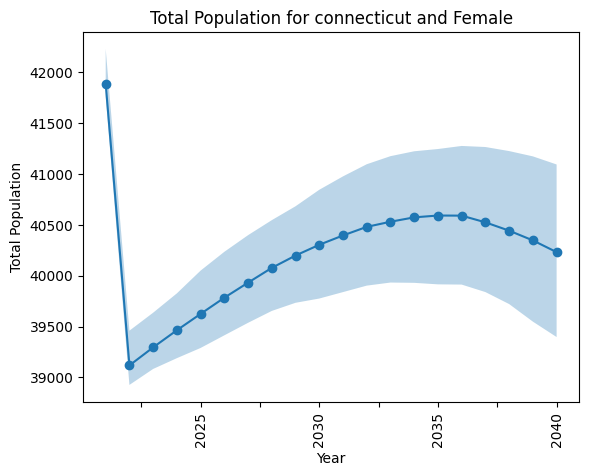

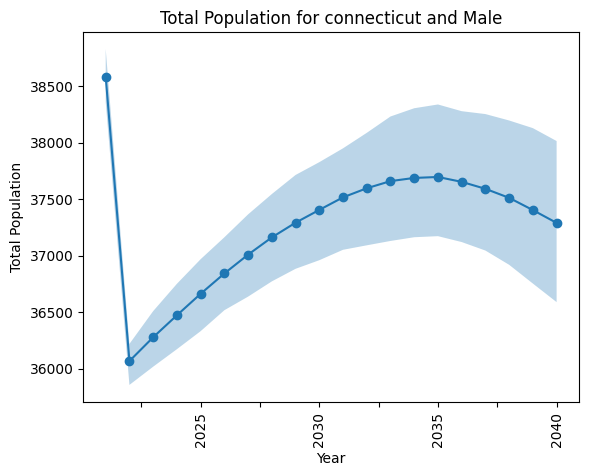

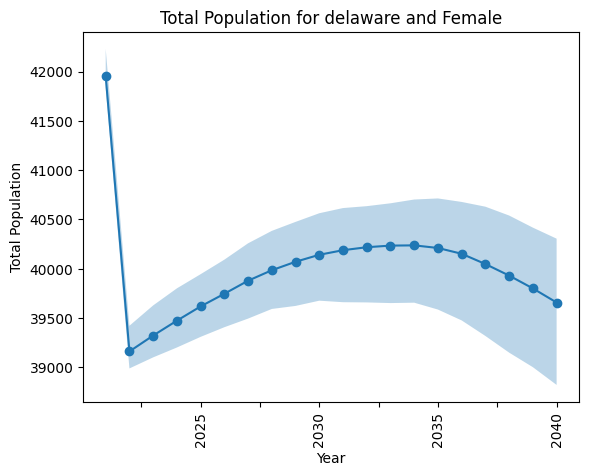

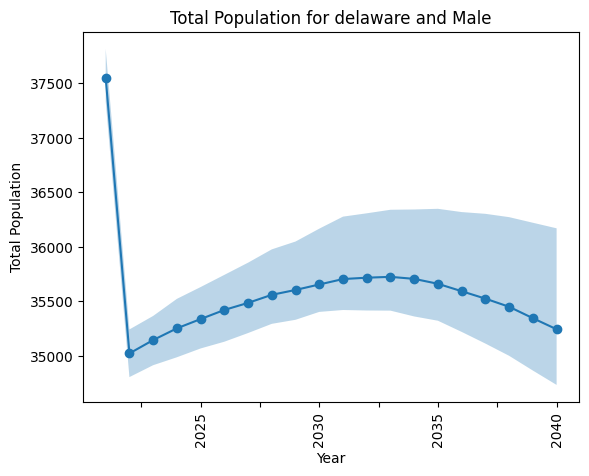

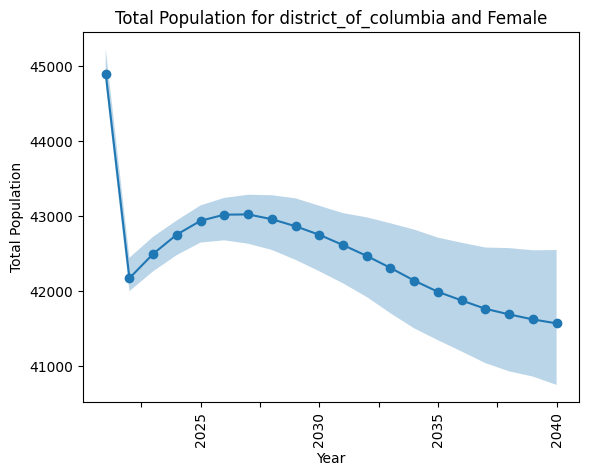

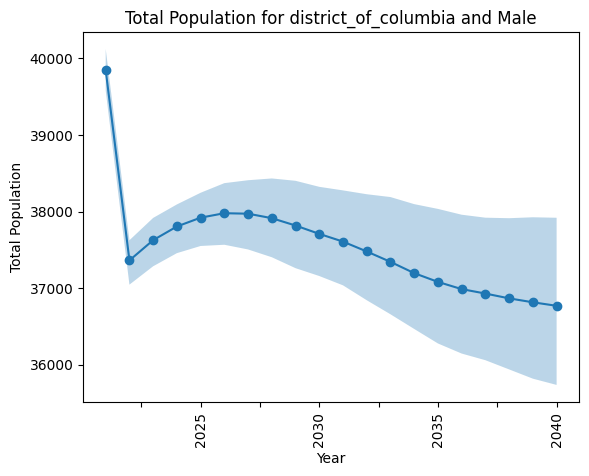

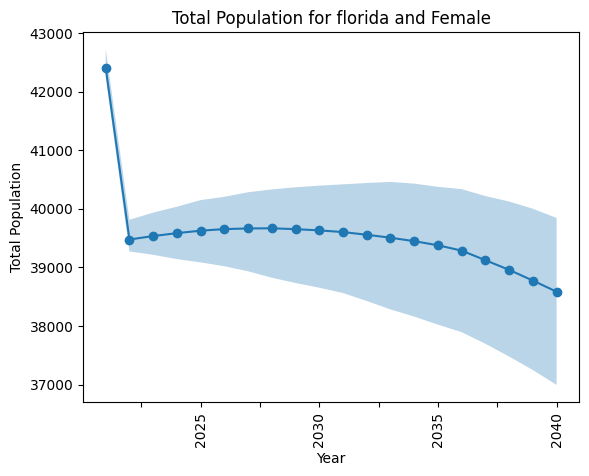

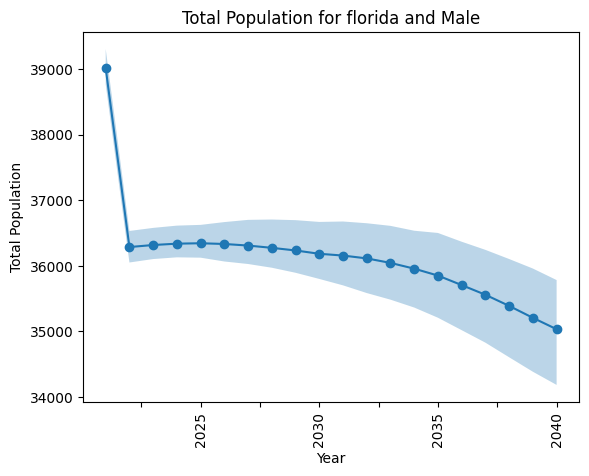

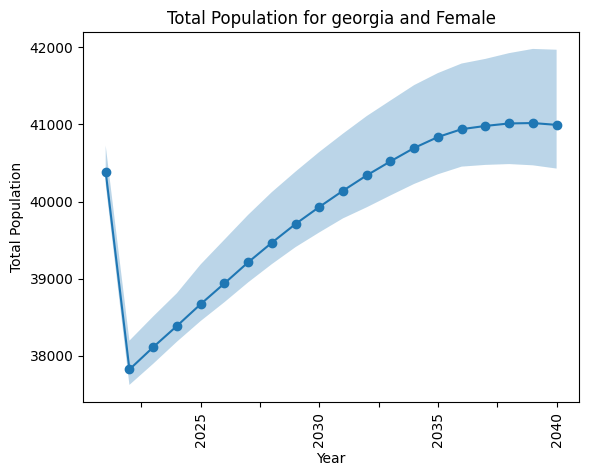

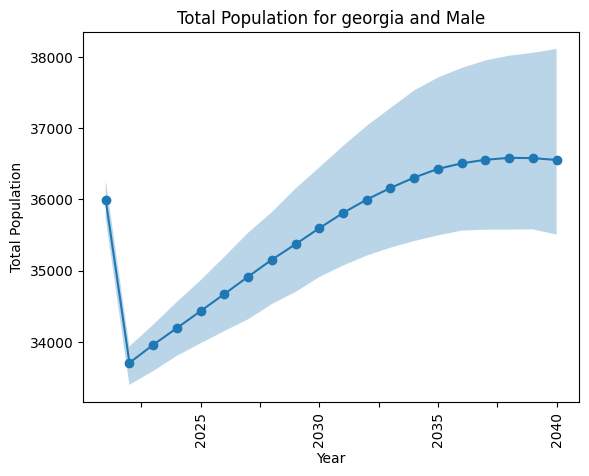

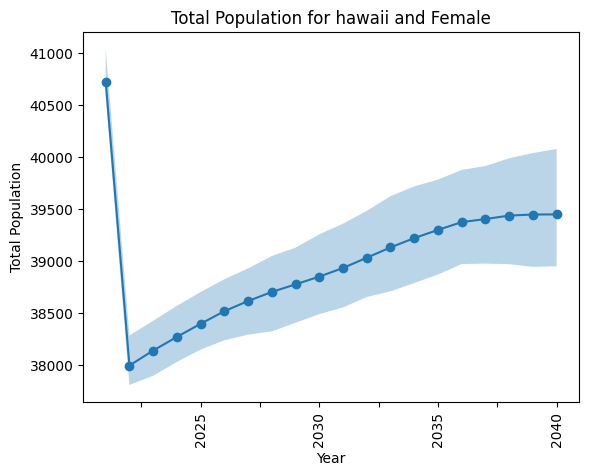

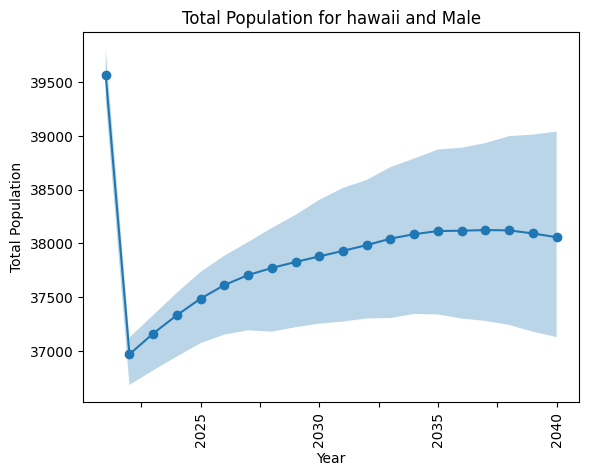

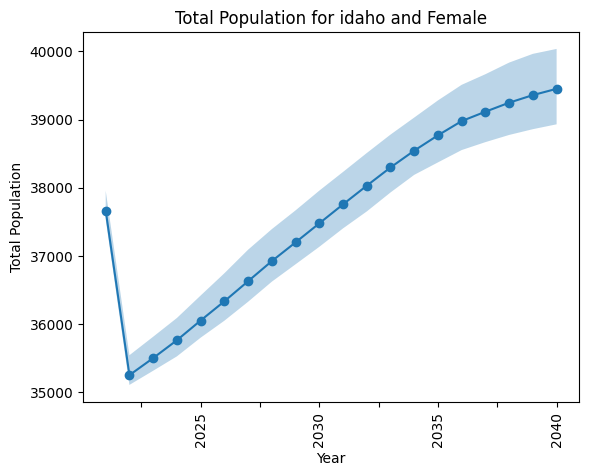

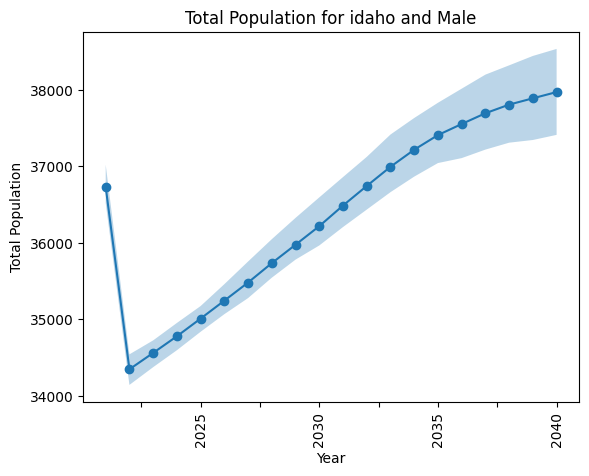

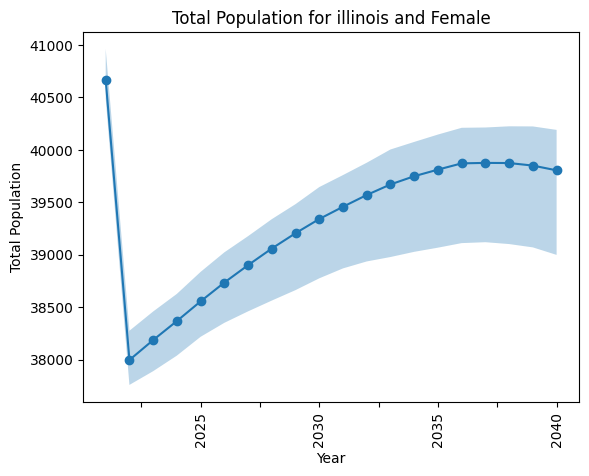

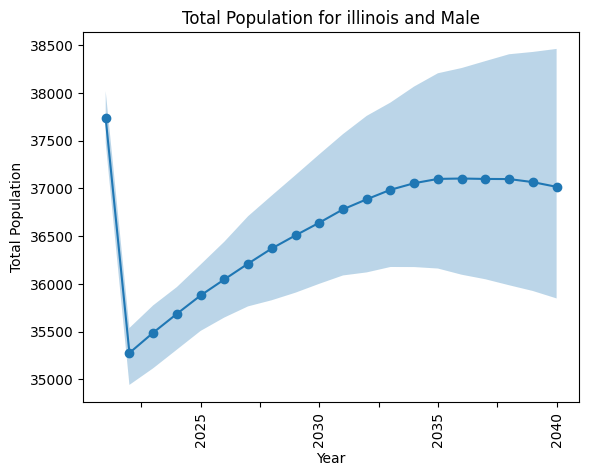

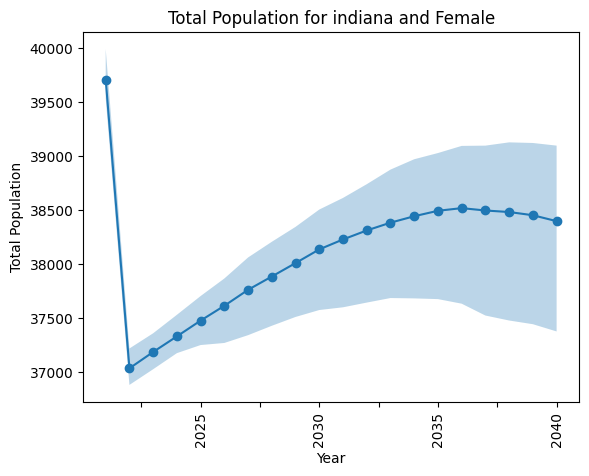

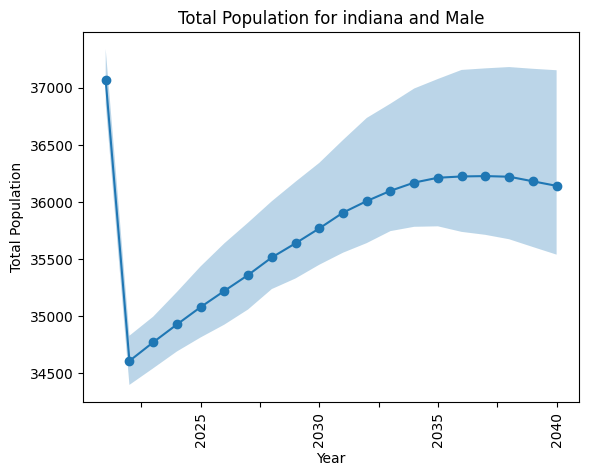

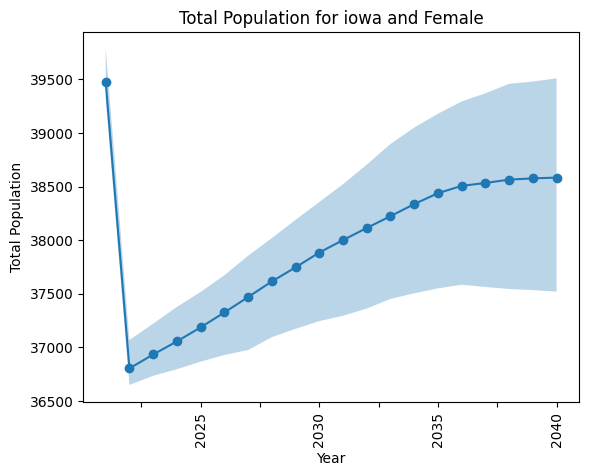

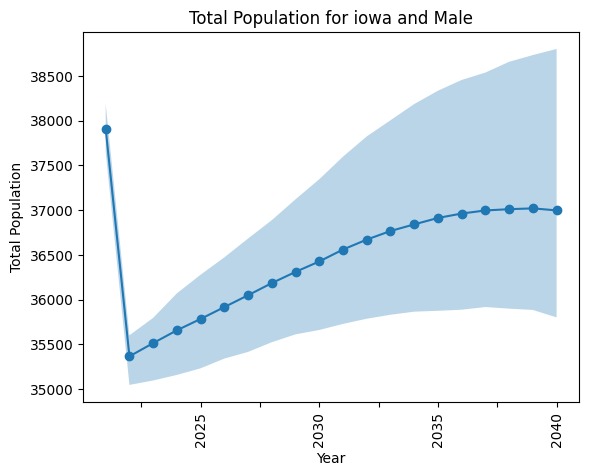

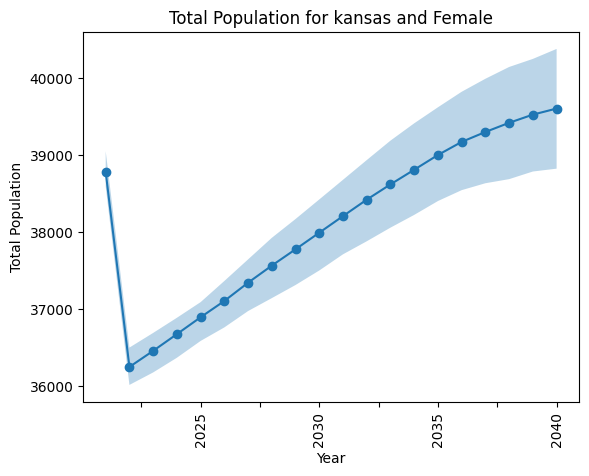

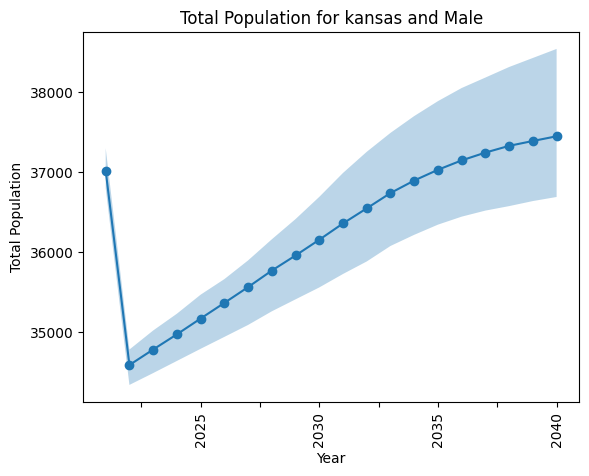

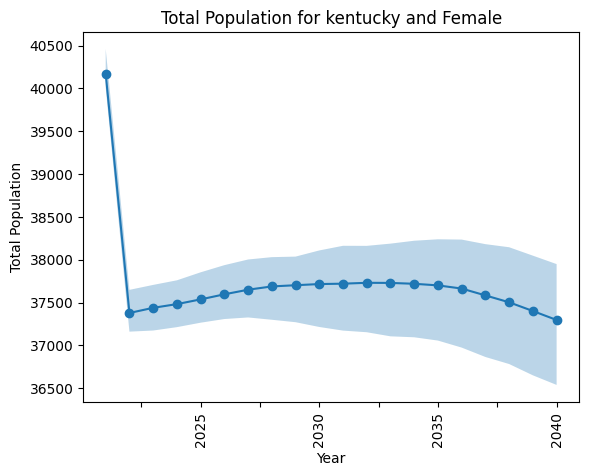

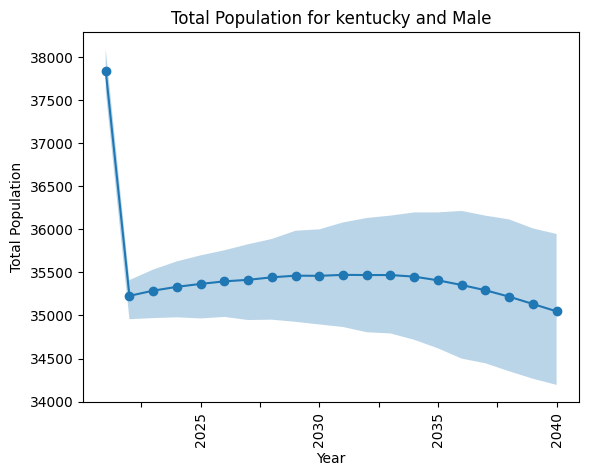

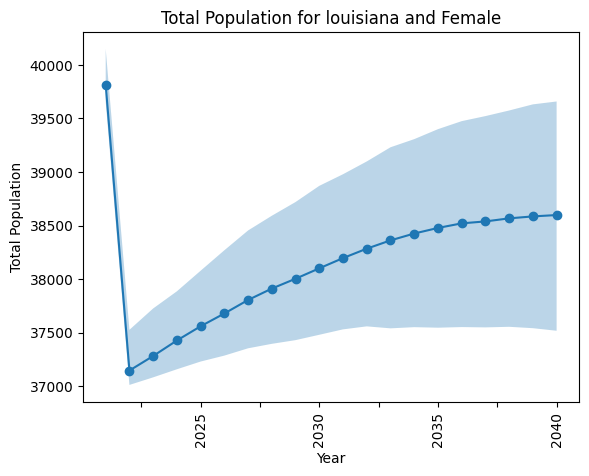

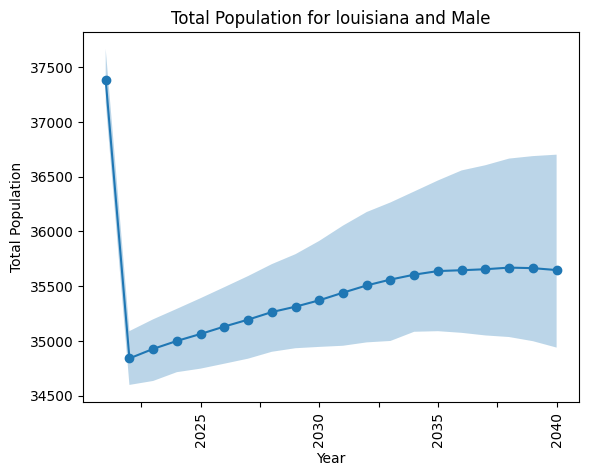

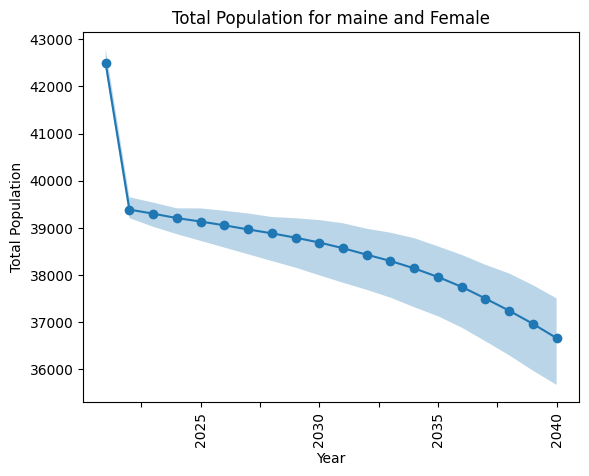

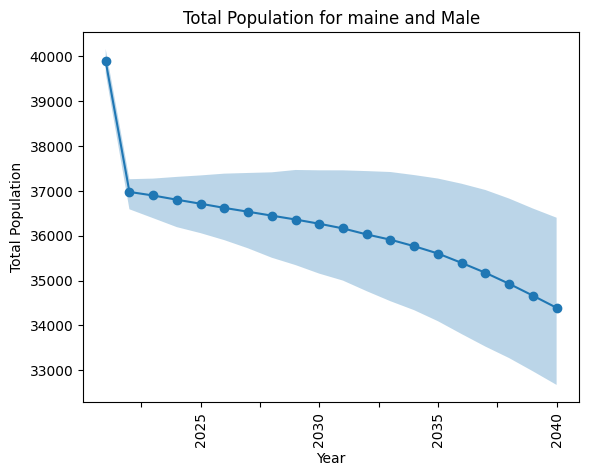

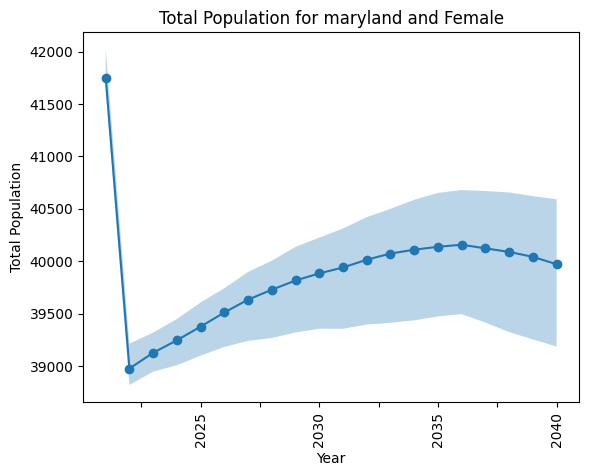

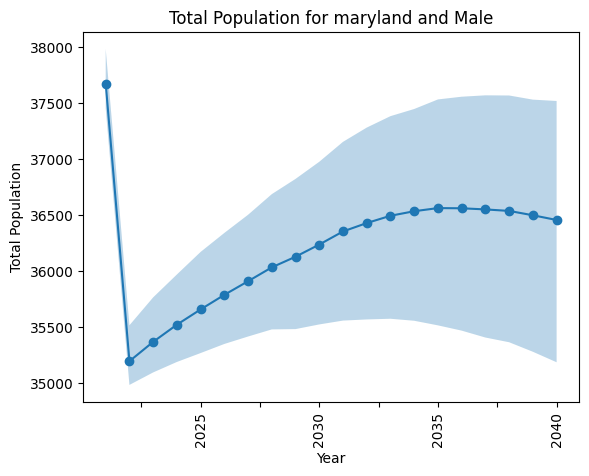

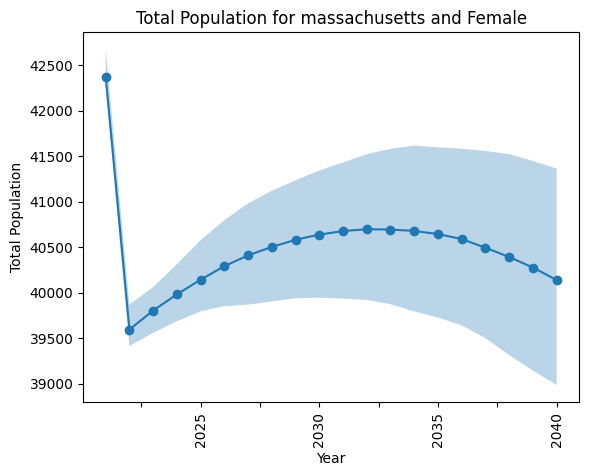

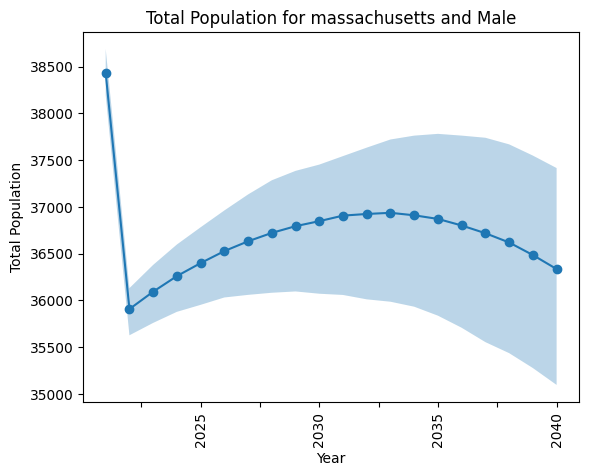

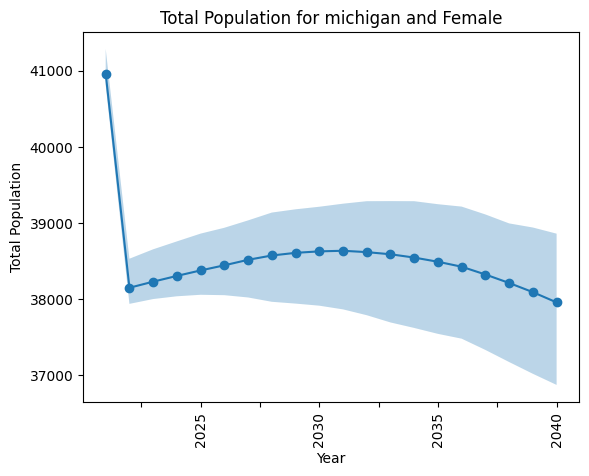

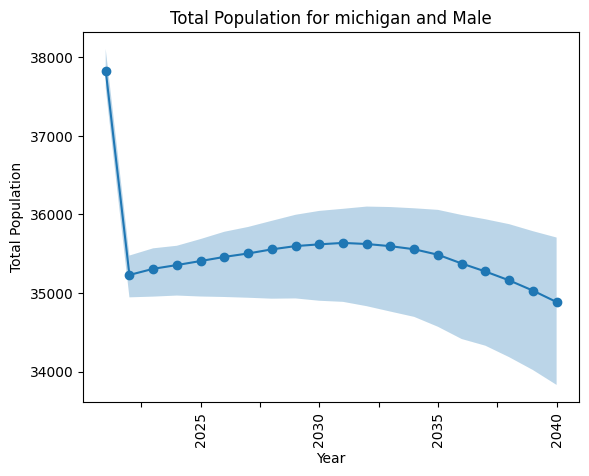

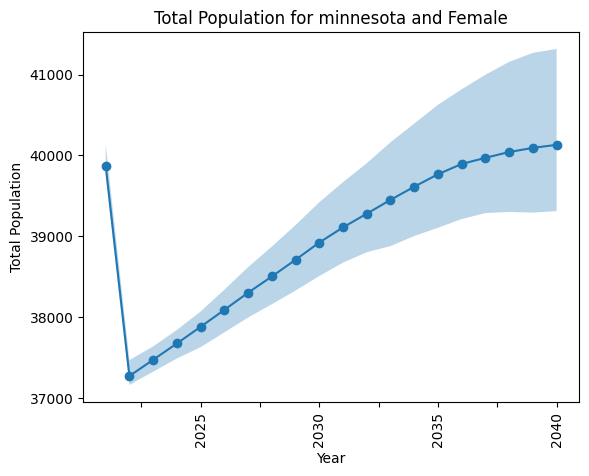

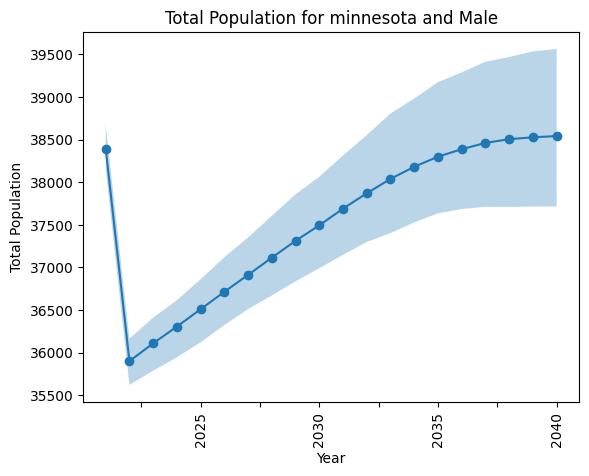

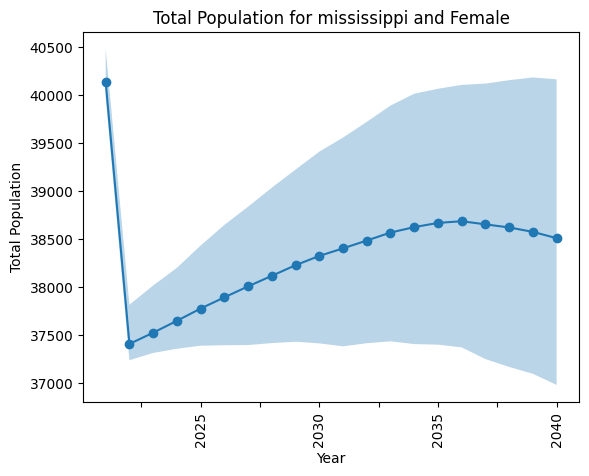

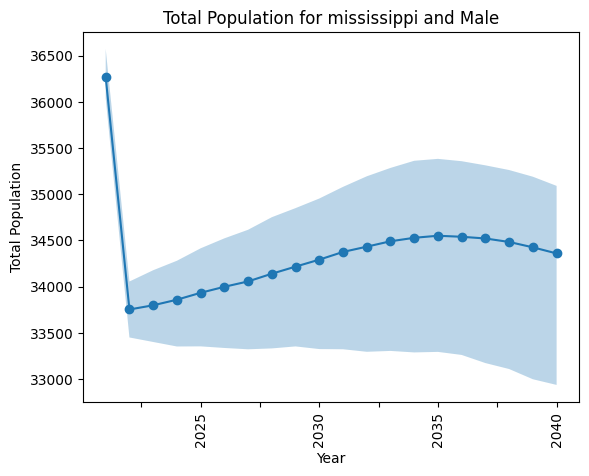

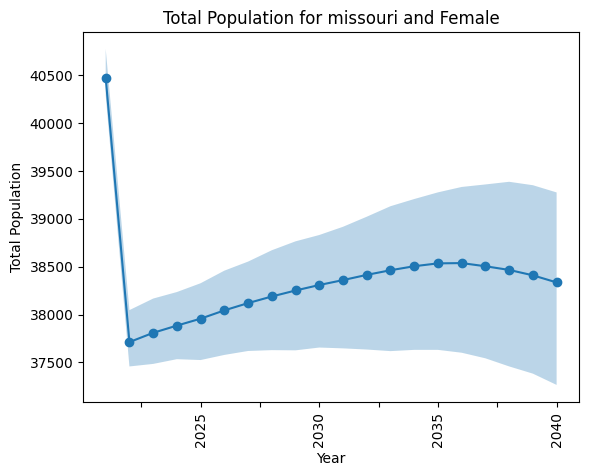

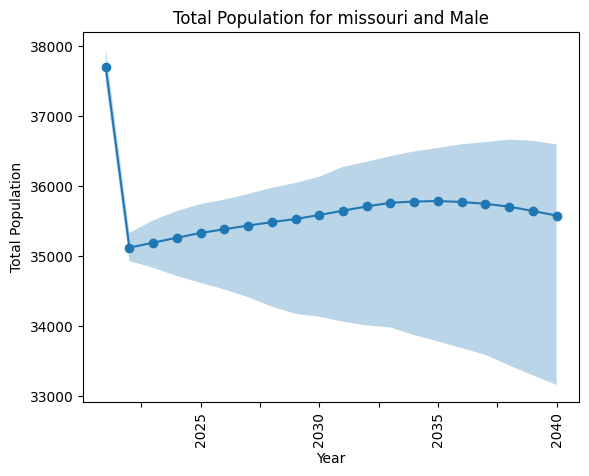

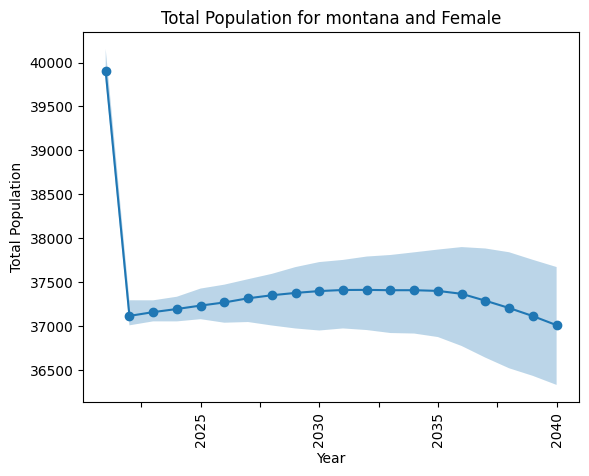

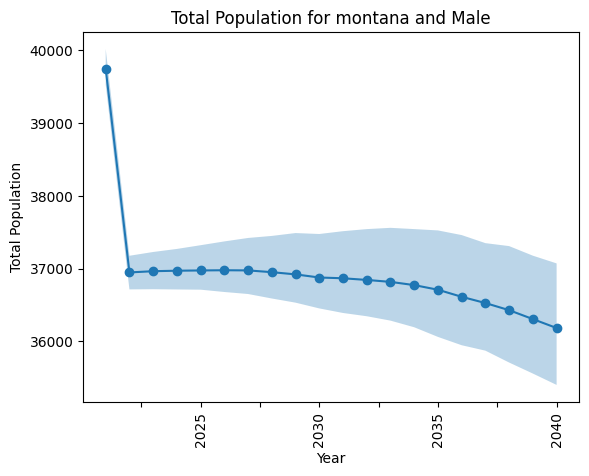

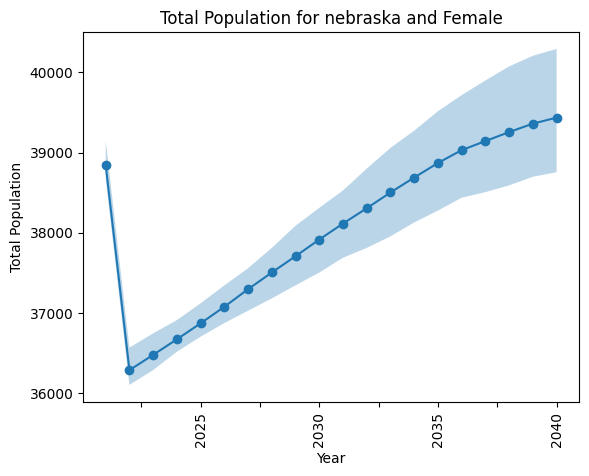

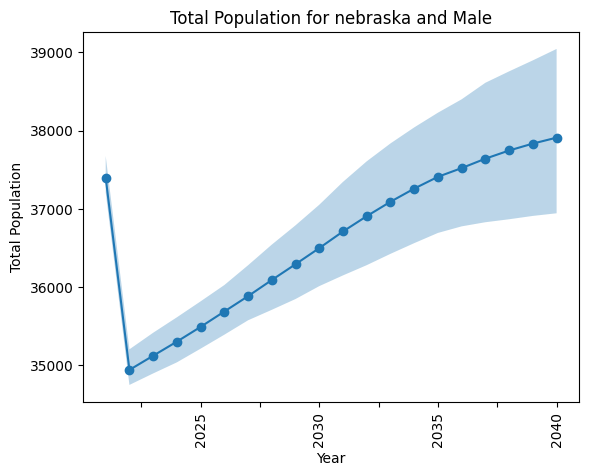

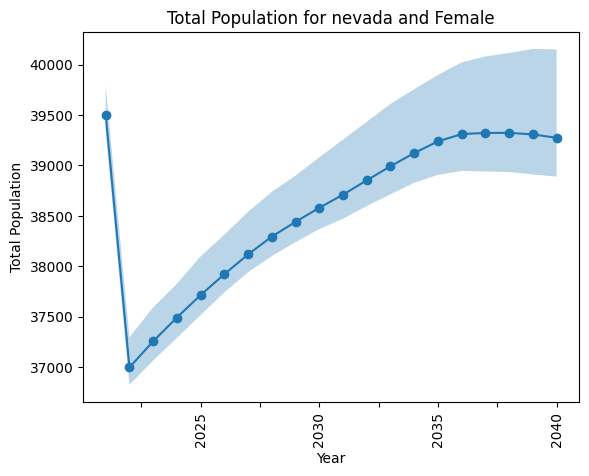

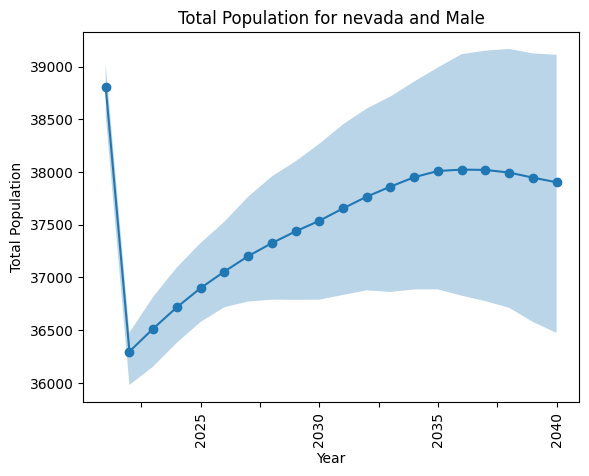

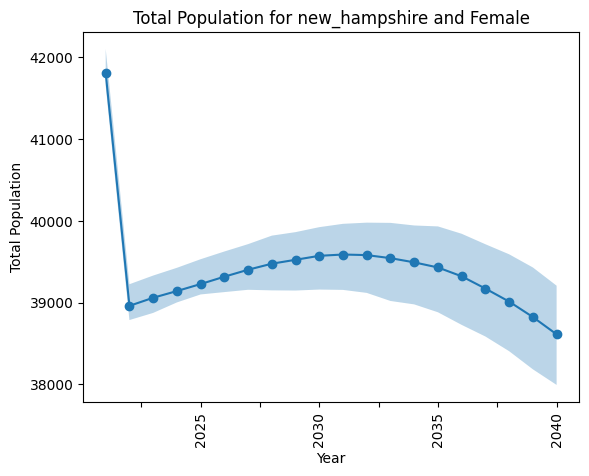

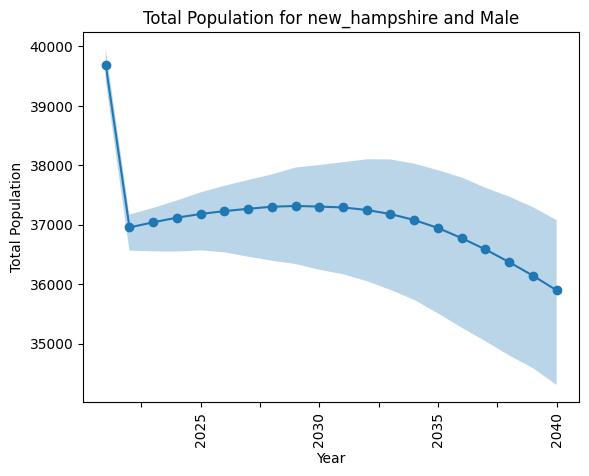

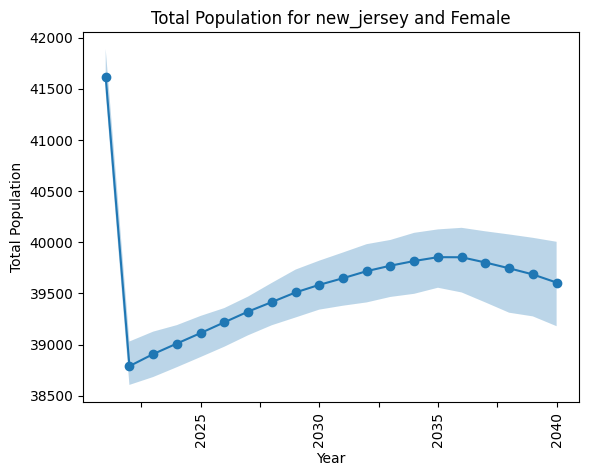

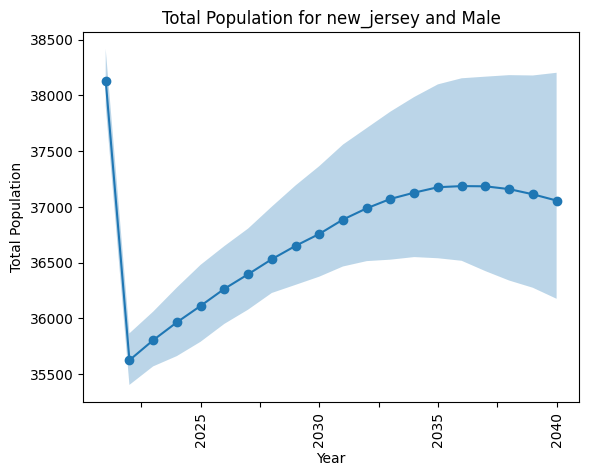

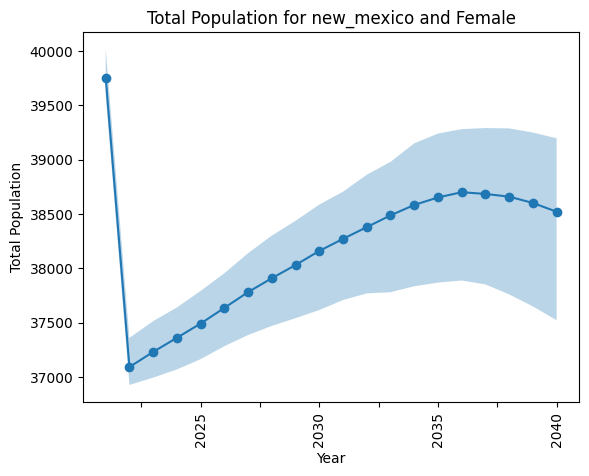

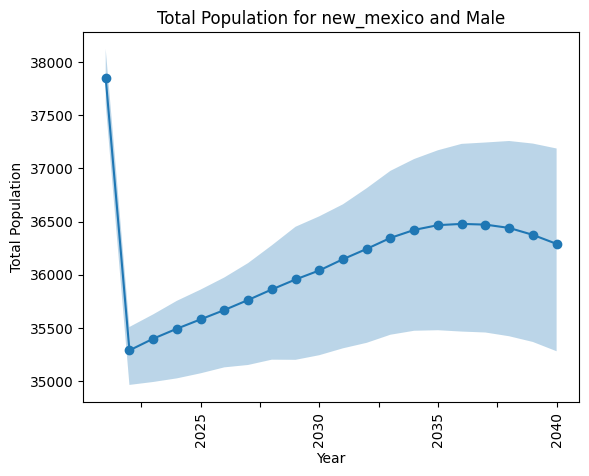

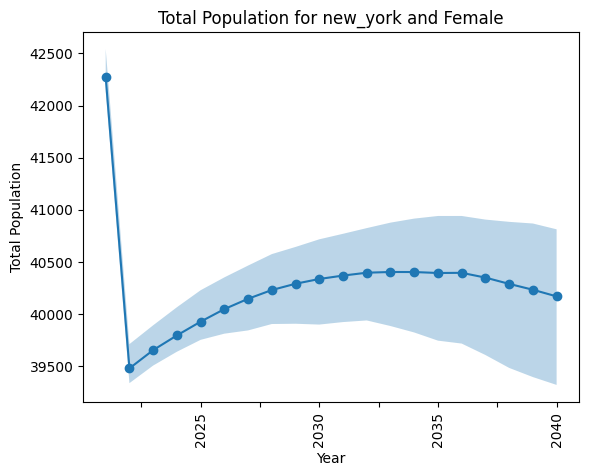

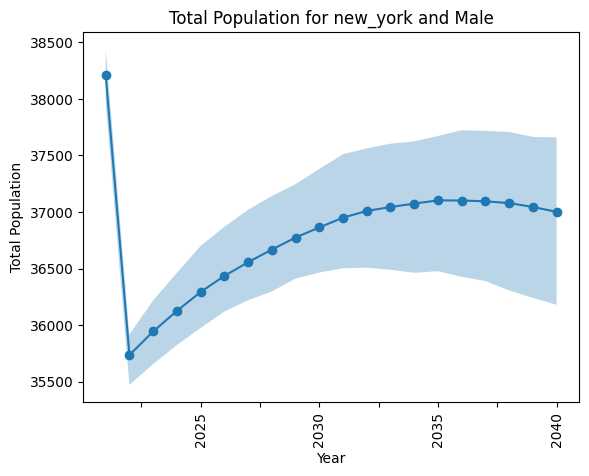

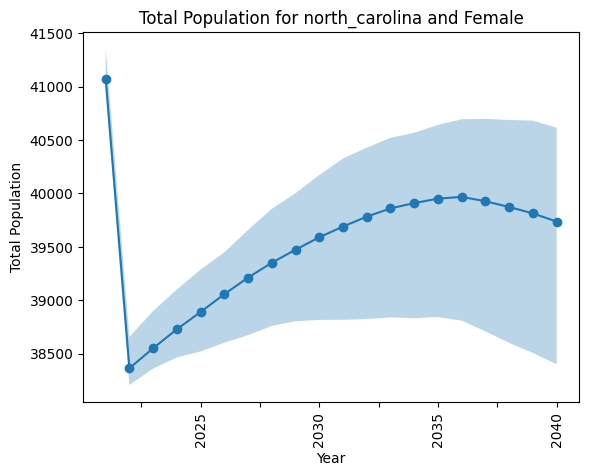

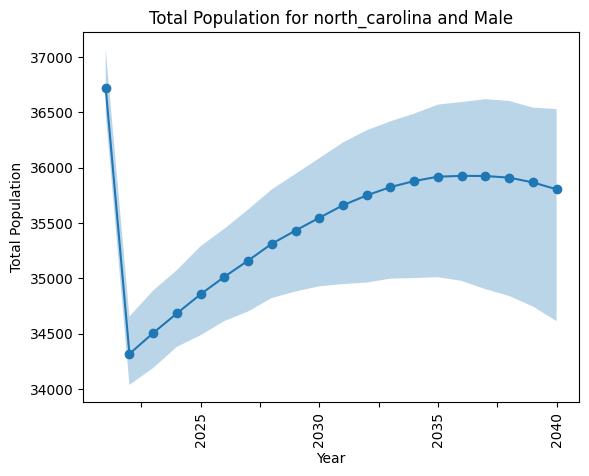

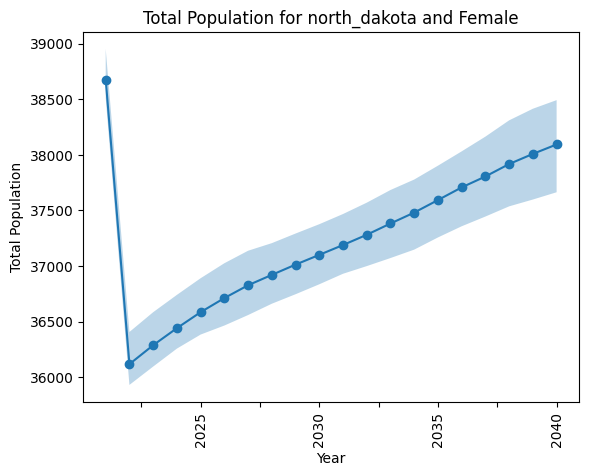

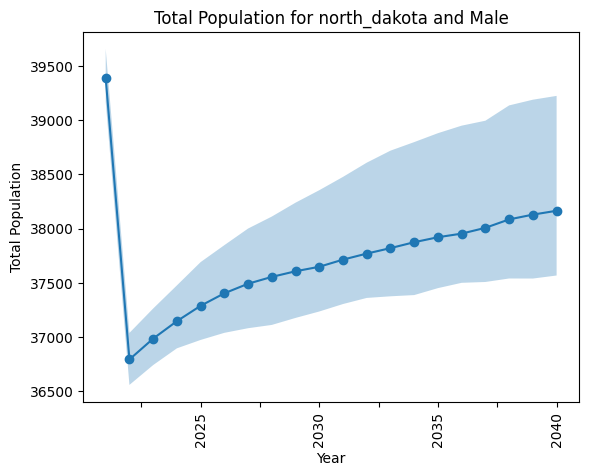

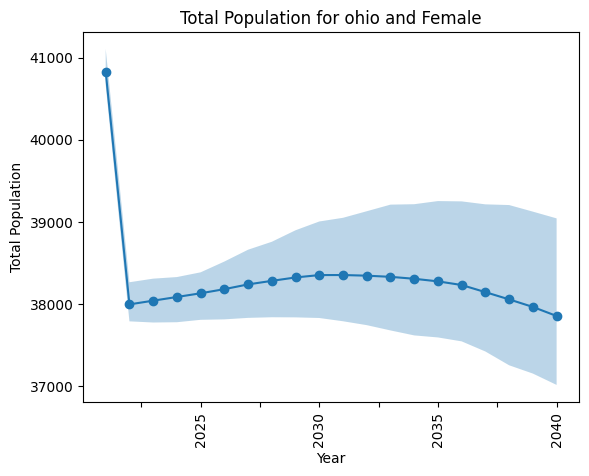

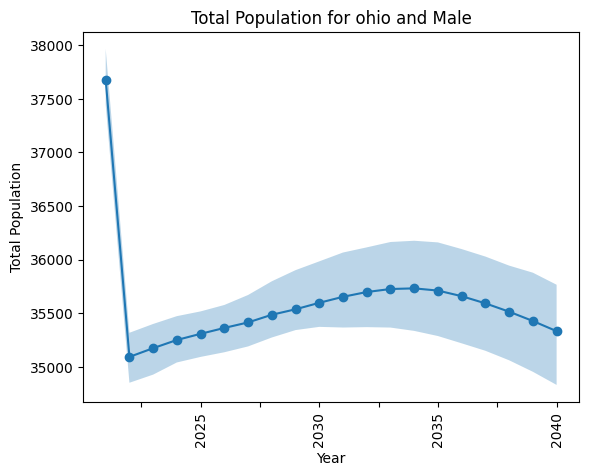

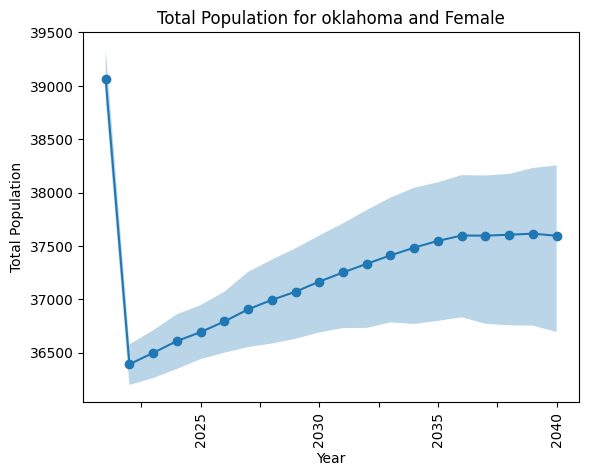

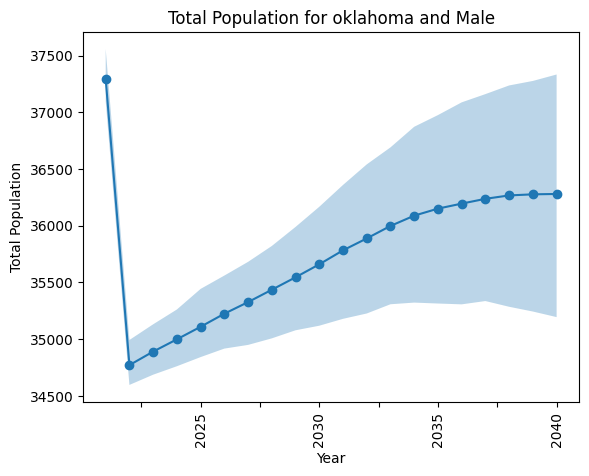

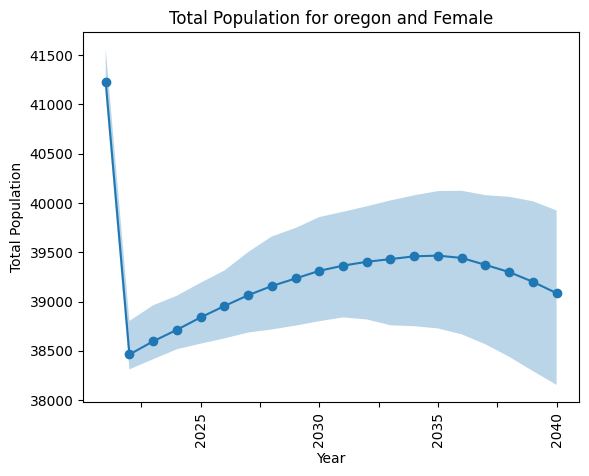

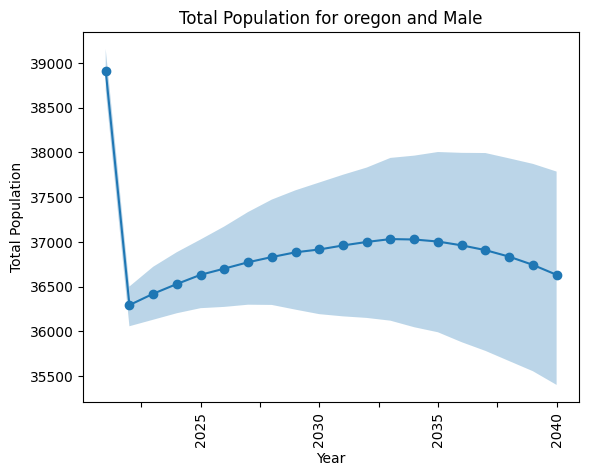

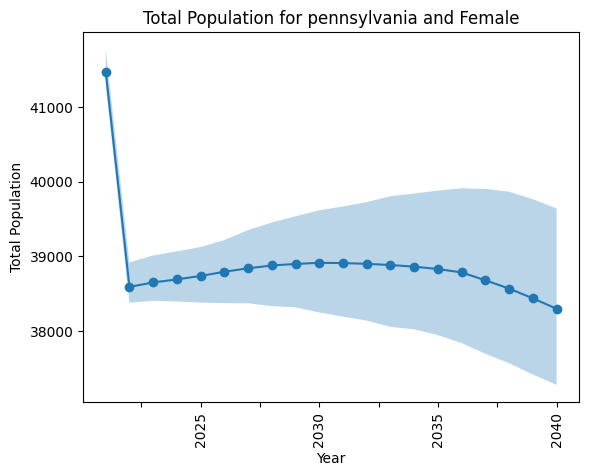

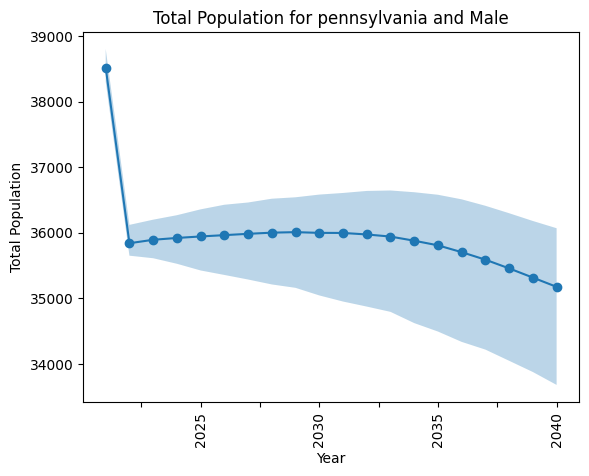

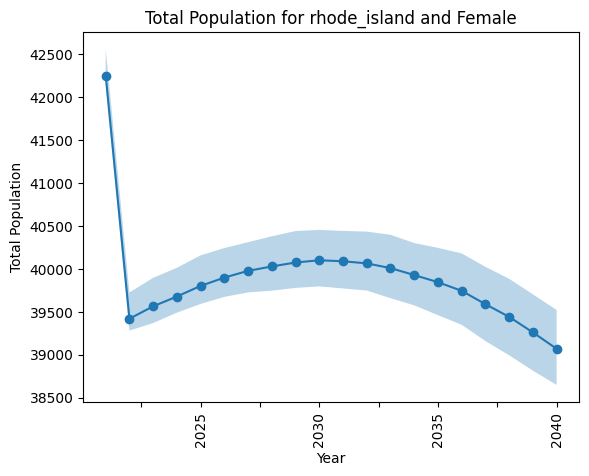

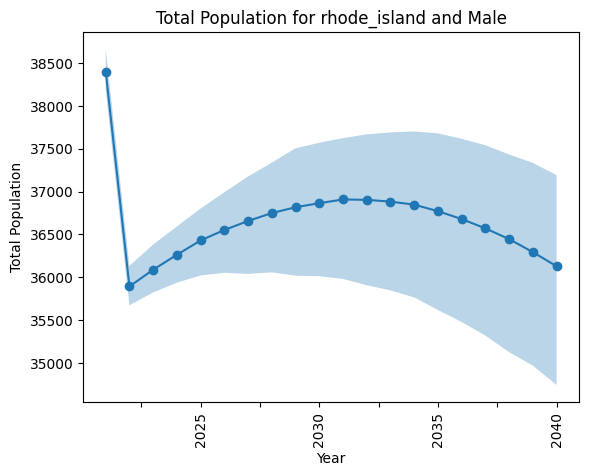

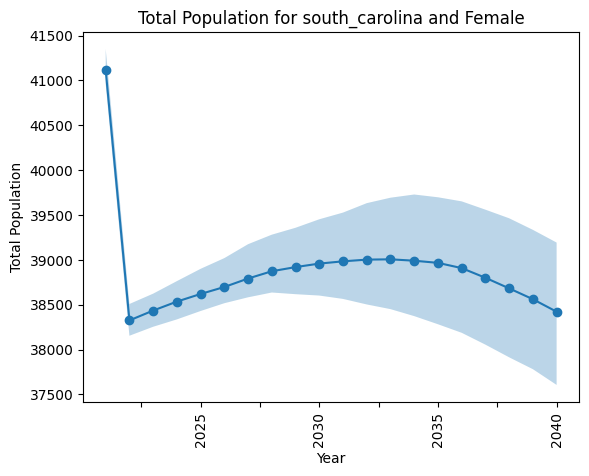

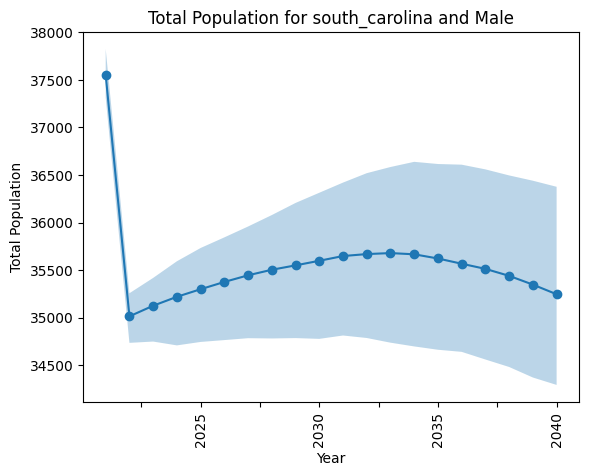

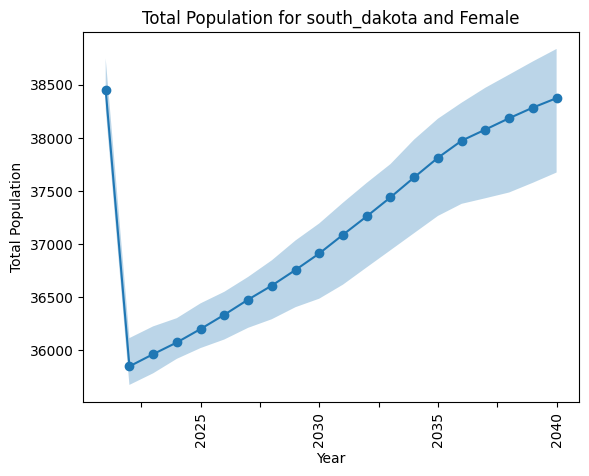

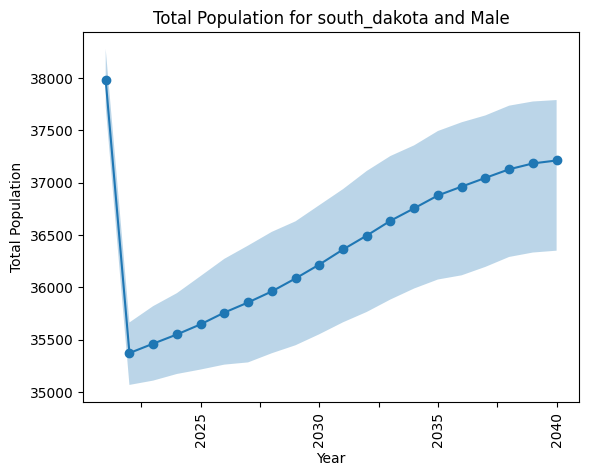

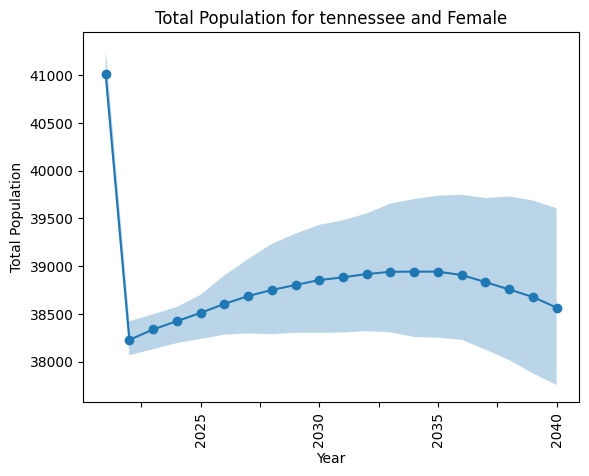

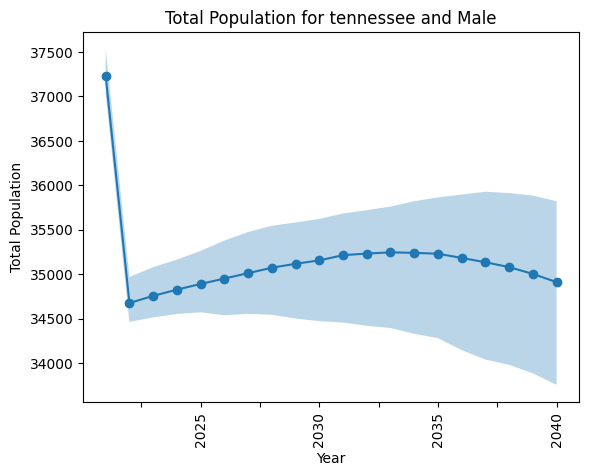

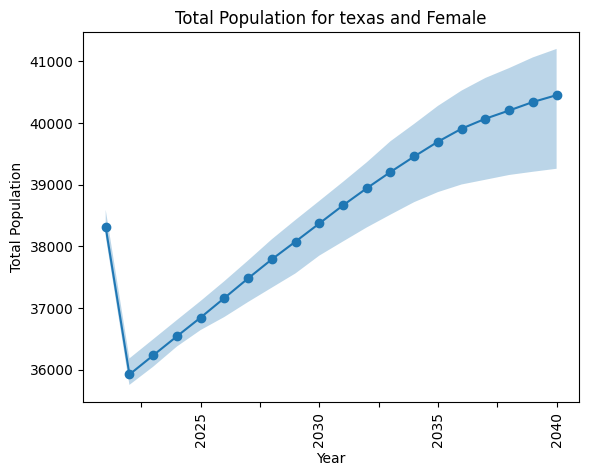

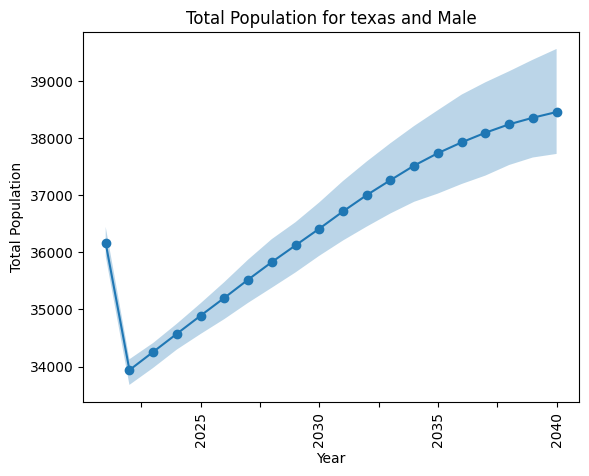

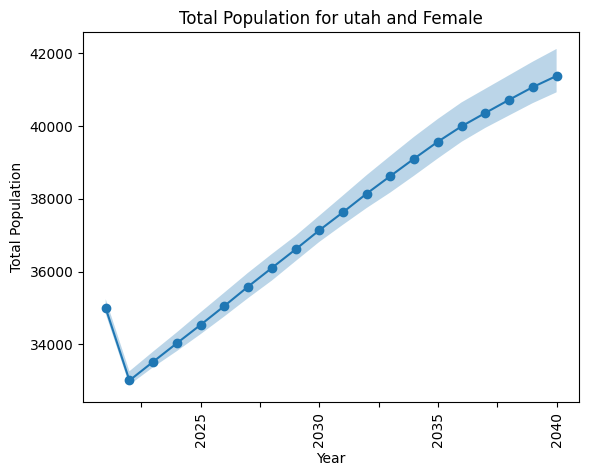

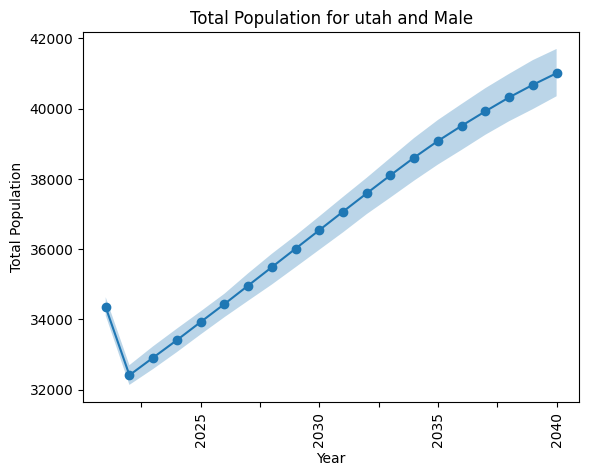

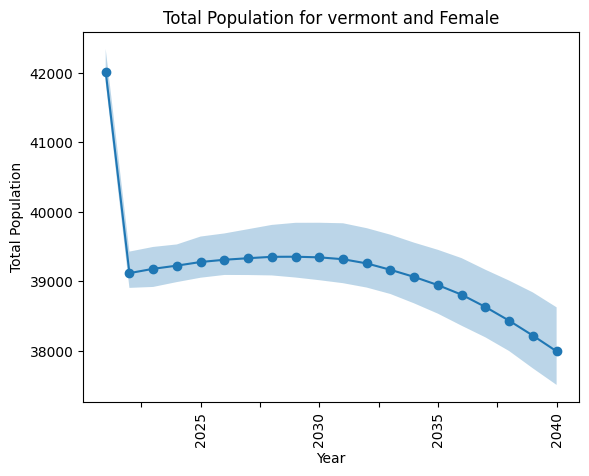

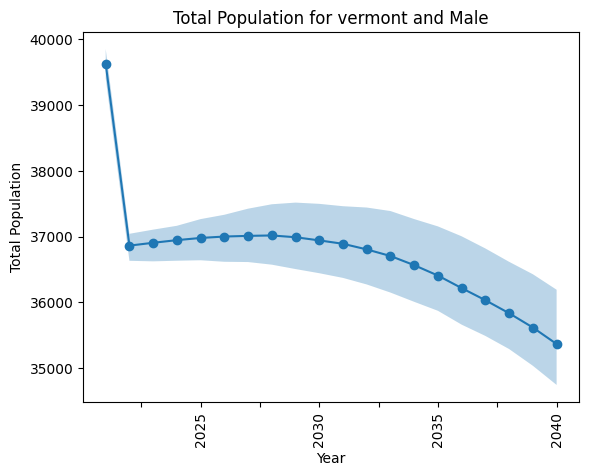

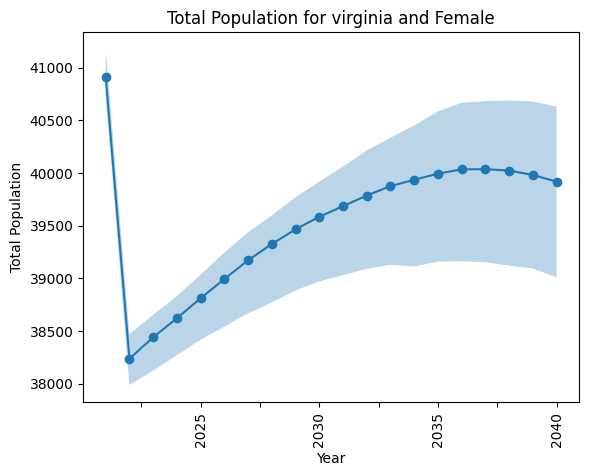

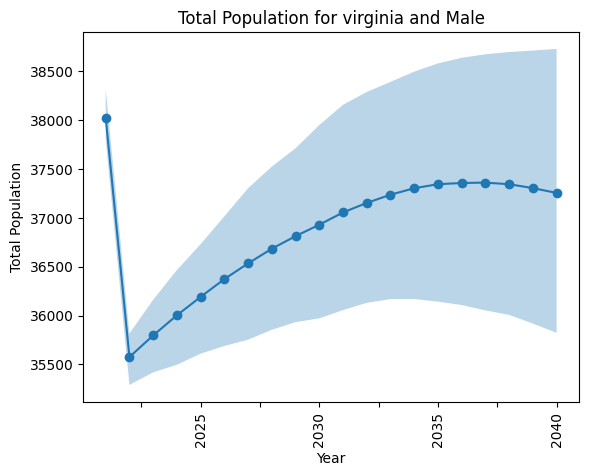

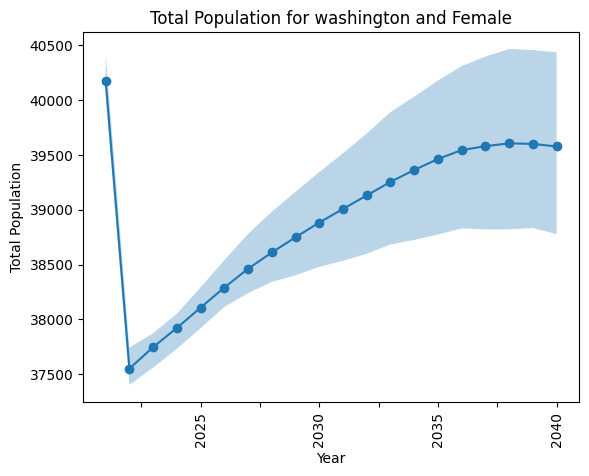

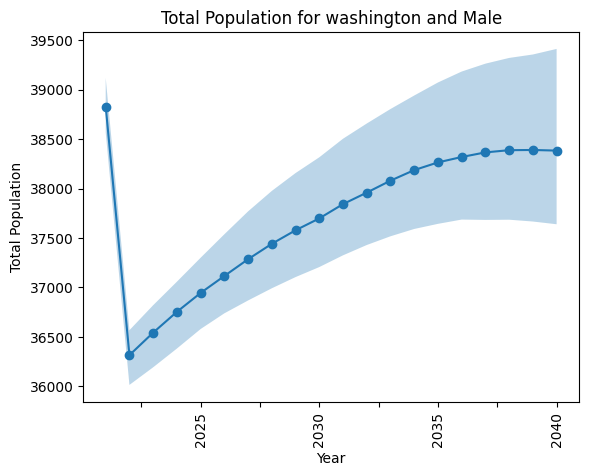

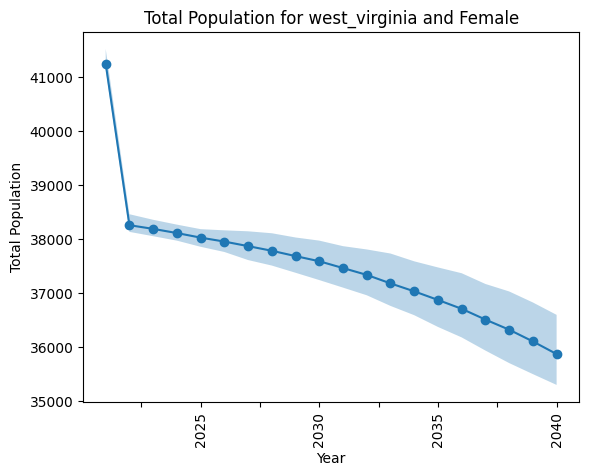

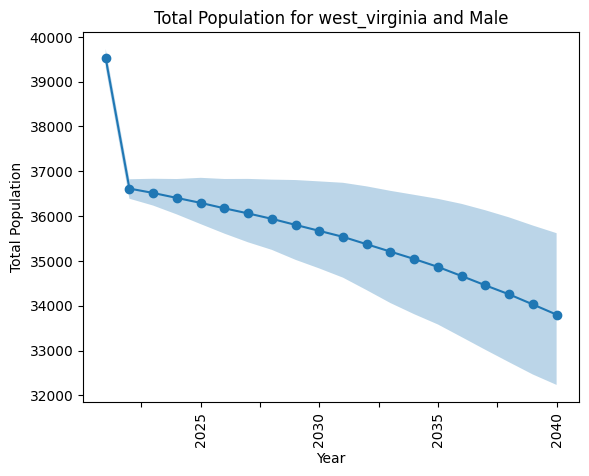

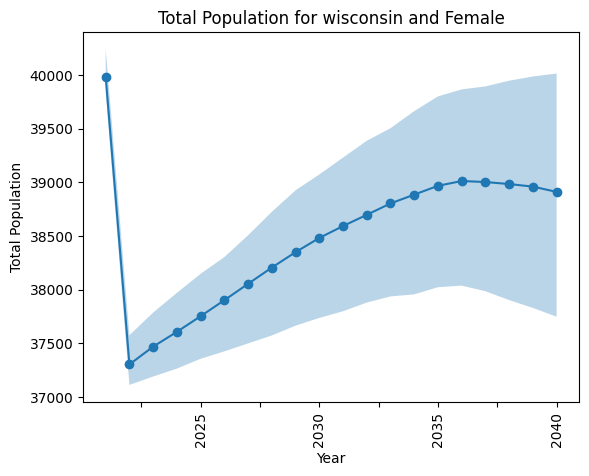

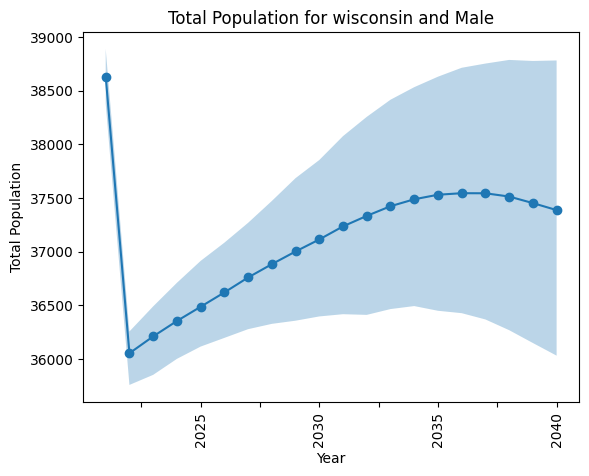

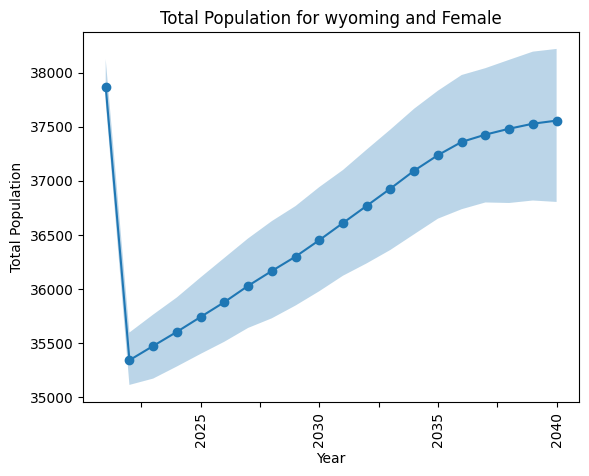

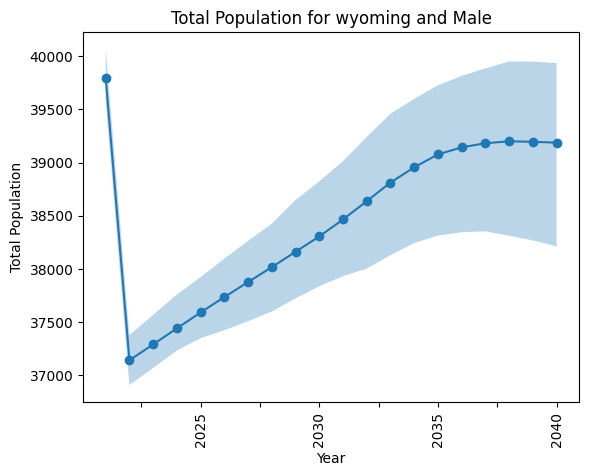

In [6]:
graph_data = all_person_time_summ 
for location in graph_data.location.unique():
    for sex in graph_data.sex.unique():
        plt.figure()
        subdata = graph_data.loc[(graph_data.sex==sex) & (graph_data.location==location)]
        plt.plot(subdata['year'], subdata['mean'], marker = 'o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        plt.title(f'Total Population for {location} and {sex}')
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        plt.ylabel(f'Total Population')

In [7]:
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
all_person_time = person_time.groupby(['age_bucket','year','input_draw','location']).value.sum().reset_index()
all_person_time = all_person_time.groupby(['age_bucket','year','location']).value.mean().reset_index()
all_buckets = all_person_time.groupby(['year','location']).value.sum().reset_index()
percentages = all_person_time.merge(all_buckets, on=['year','location'])
percentages['percent'] = percentages['value_x'] / percentages['value_y'] * 100
percentages.head()

age_bucket  year location       value_x       value_y    percent
0   45_to_65  2021  alabama  29340.442984  78152.135797  37.542727
1   65_to_85  2021  alabama  17338.182615  78152.135797  22.185168
2    over_85  2021  alabama   2092.153867  78152.135797   2.677027
3   under_45  2021  alabama  29381.356331  78152.135797  37.595078
4   45_to_65  2021   alaska  28605.474606  76384.873922  37.449135

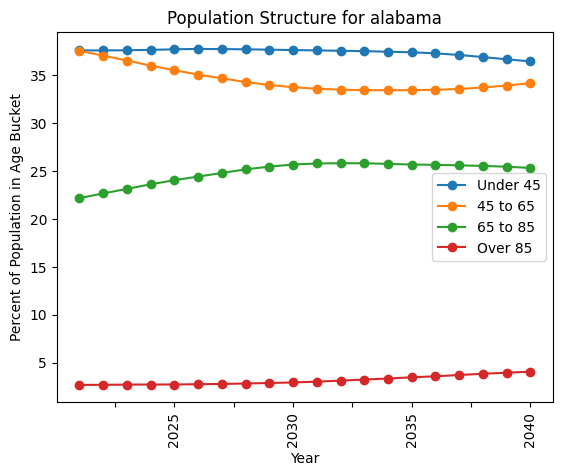

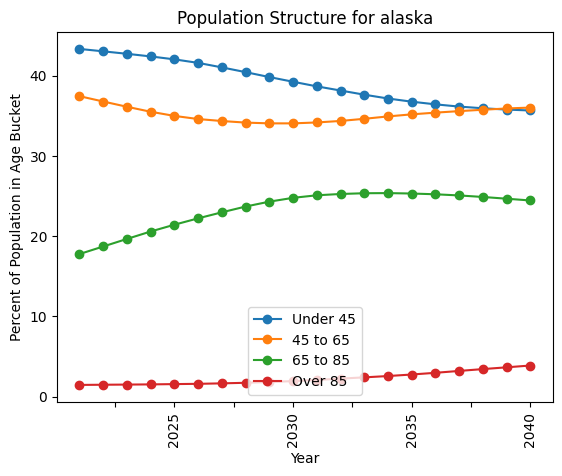

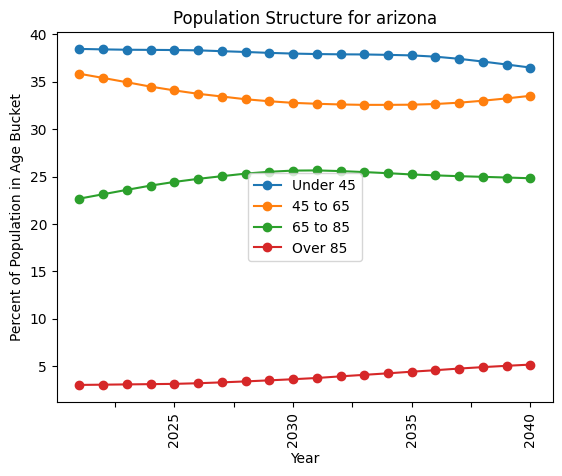

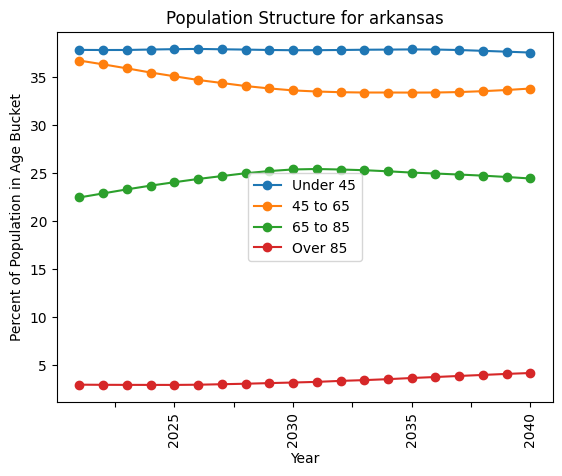

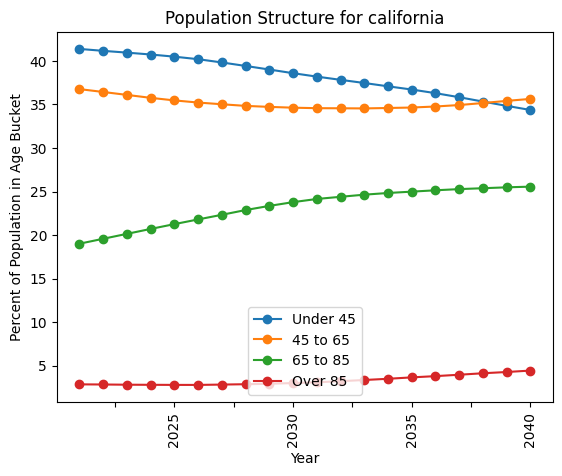

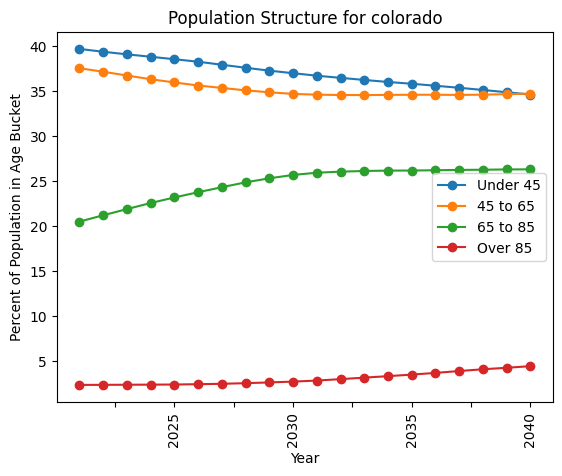

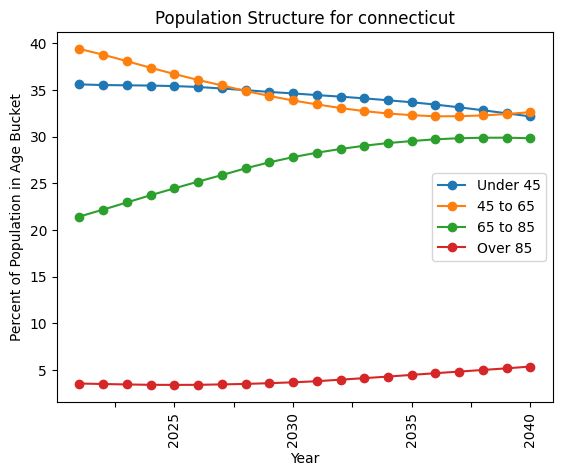

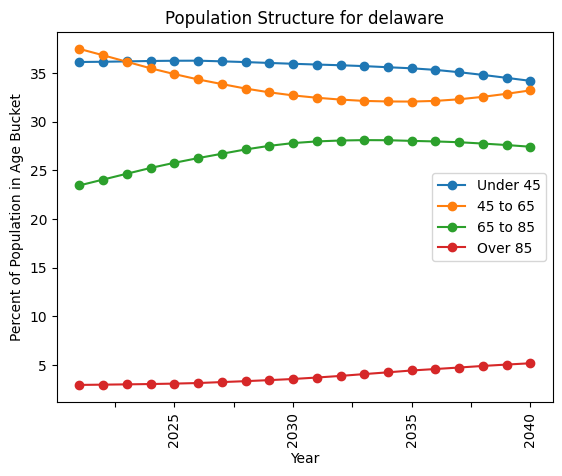

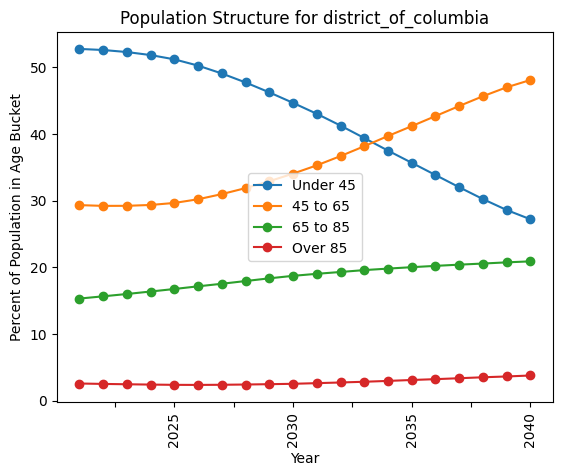

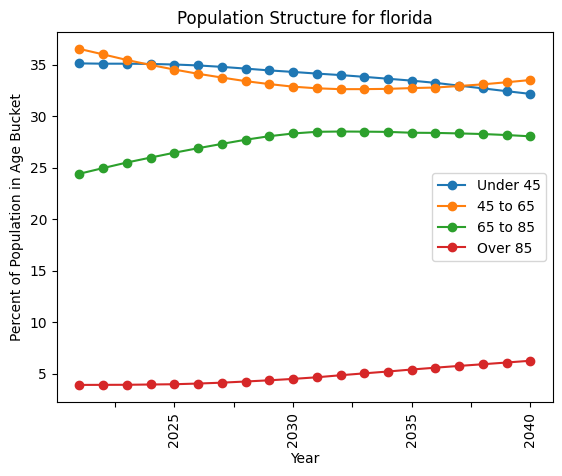

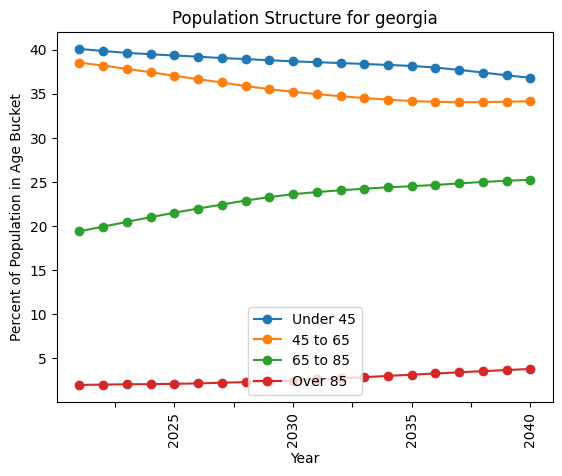

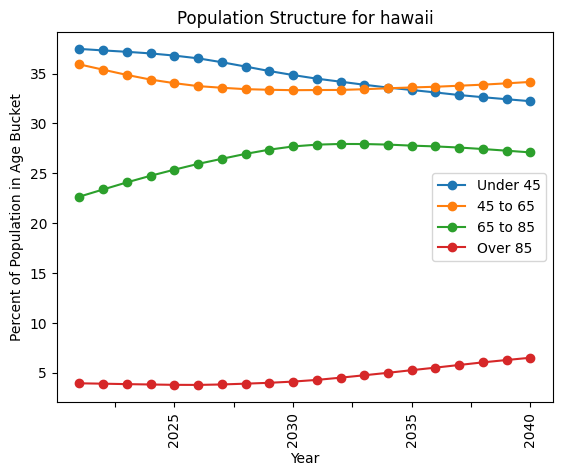

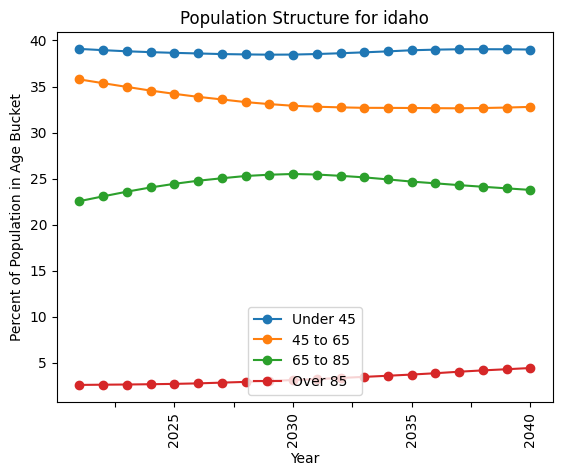

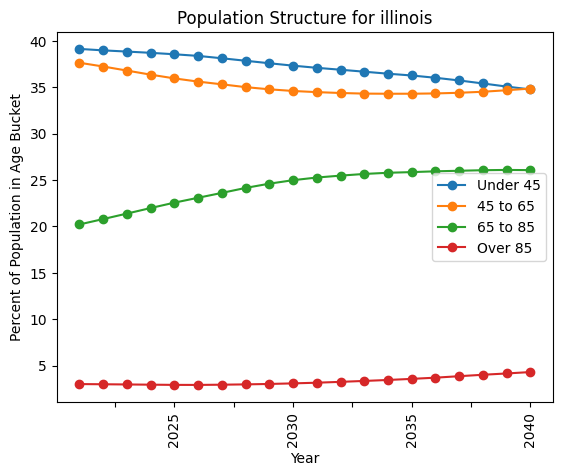

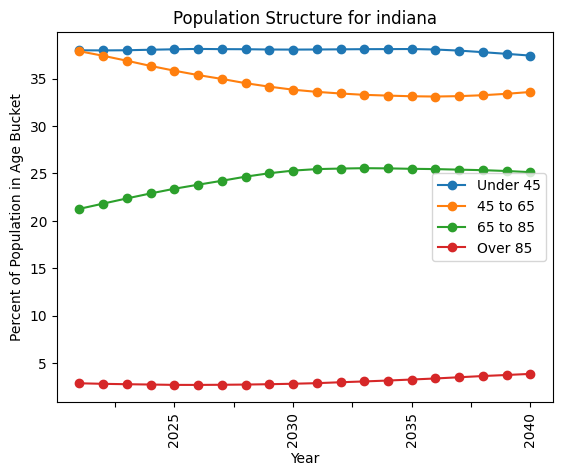

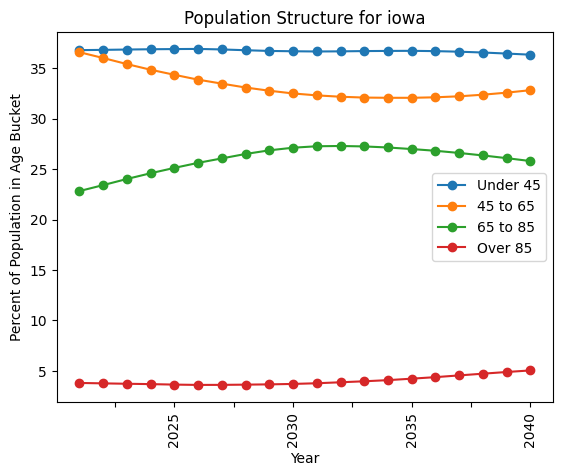

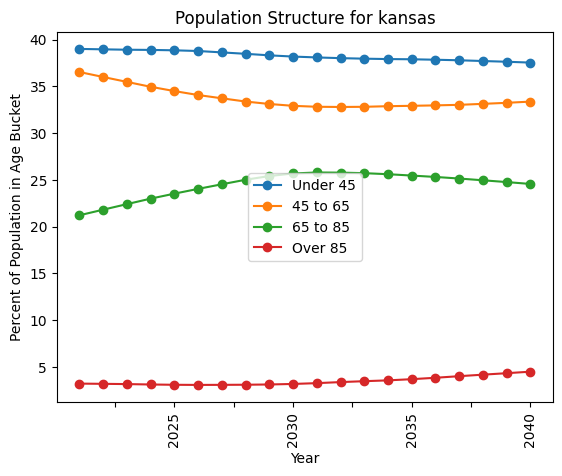

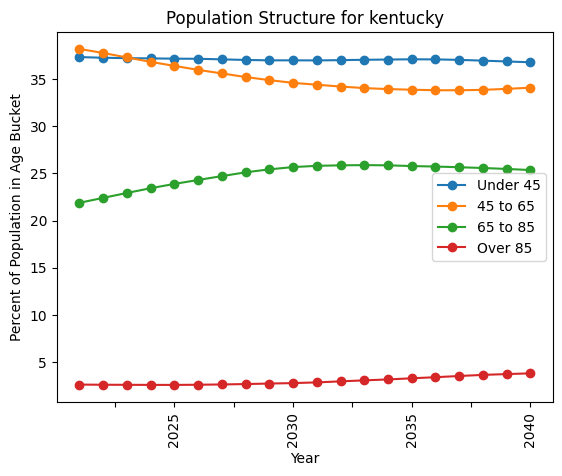

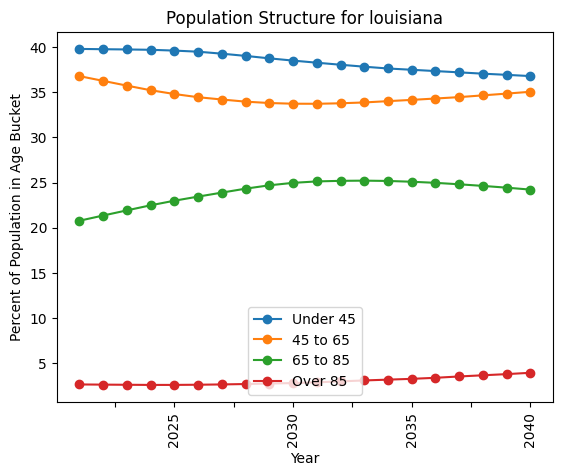

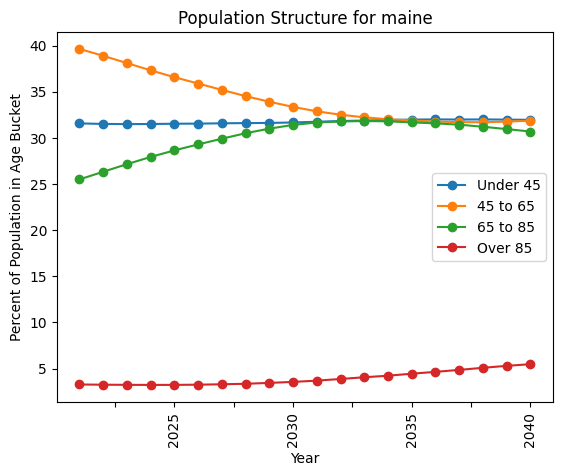

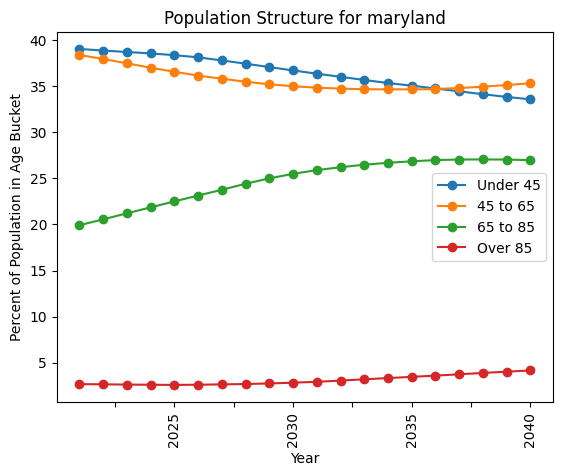

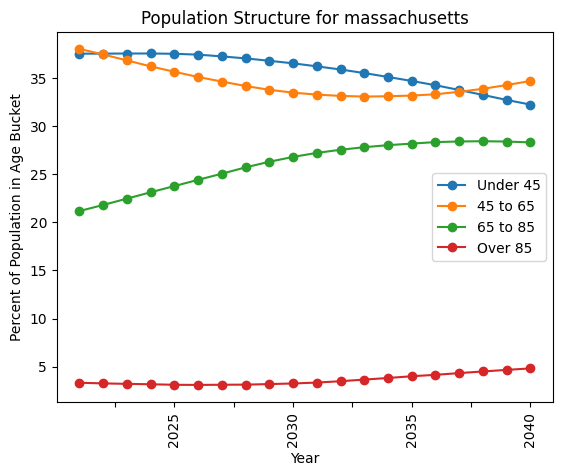

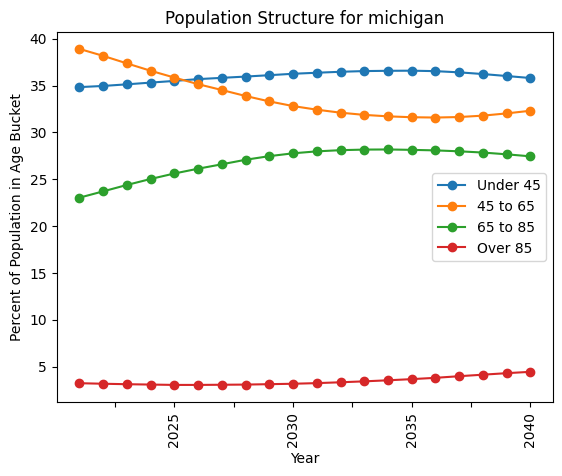

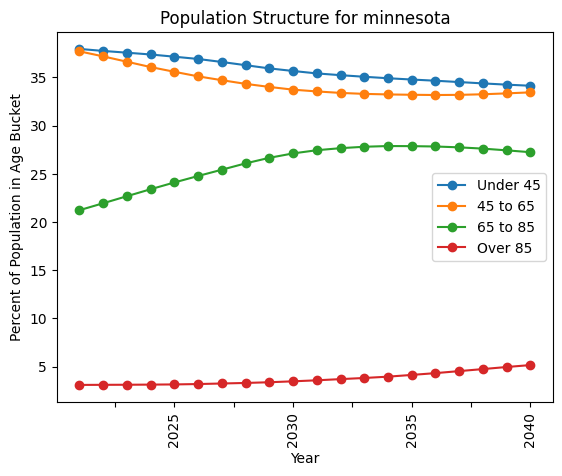

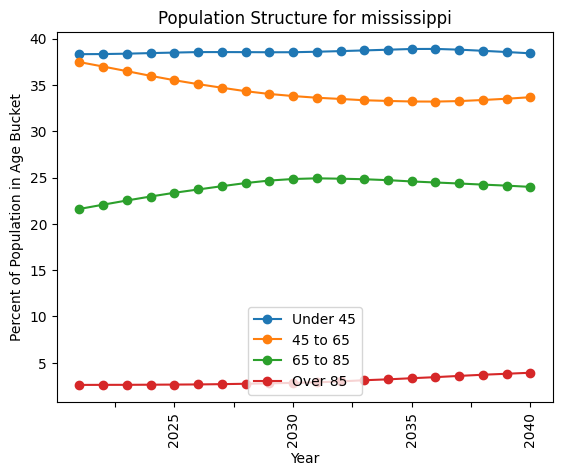

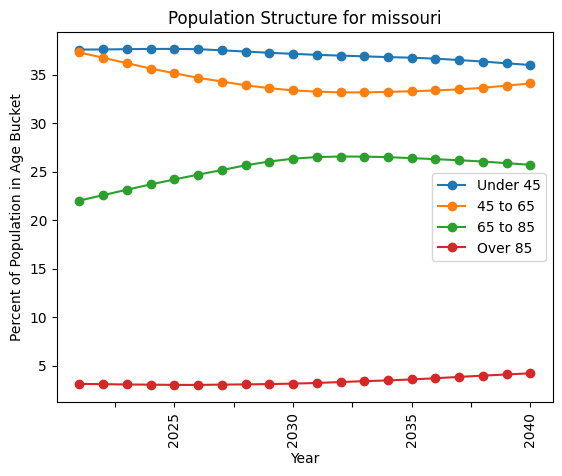

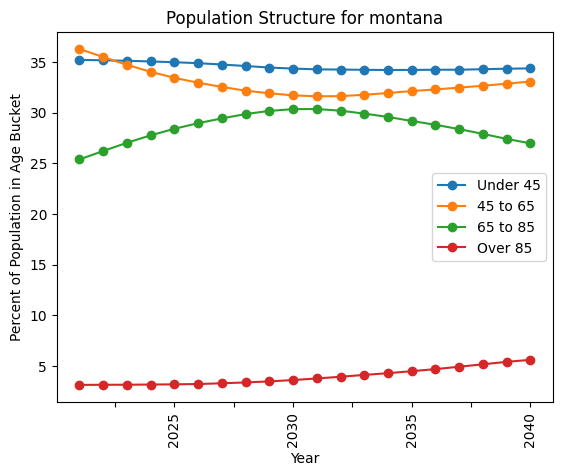

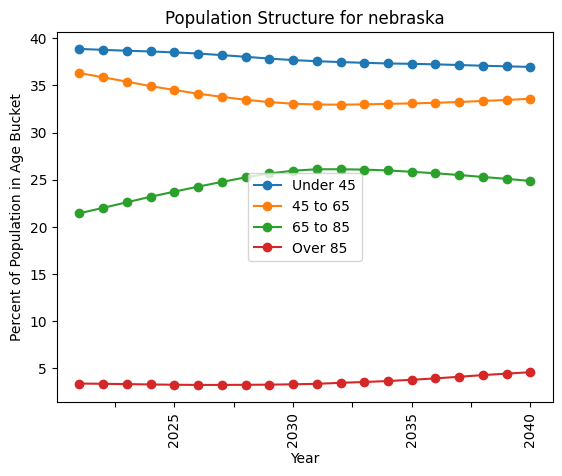

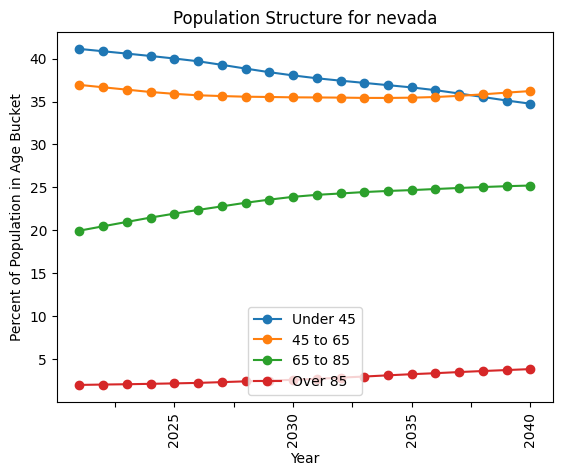

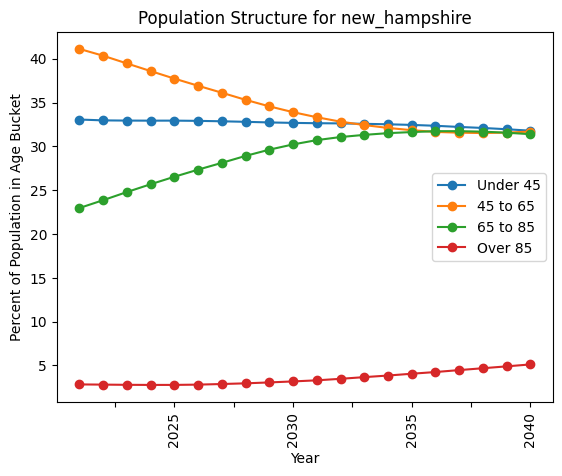

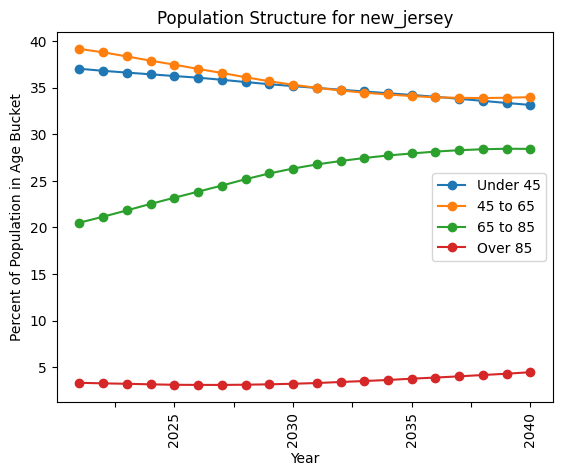

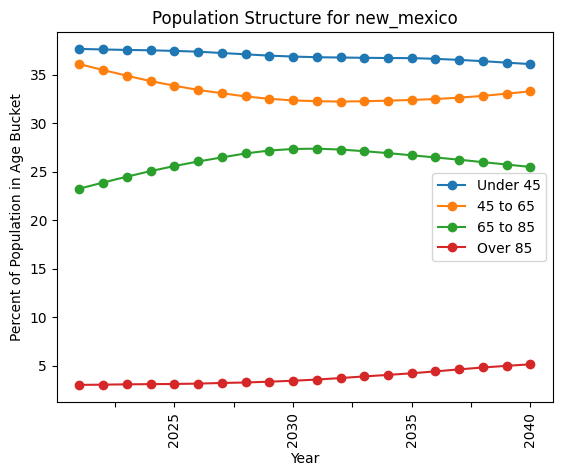

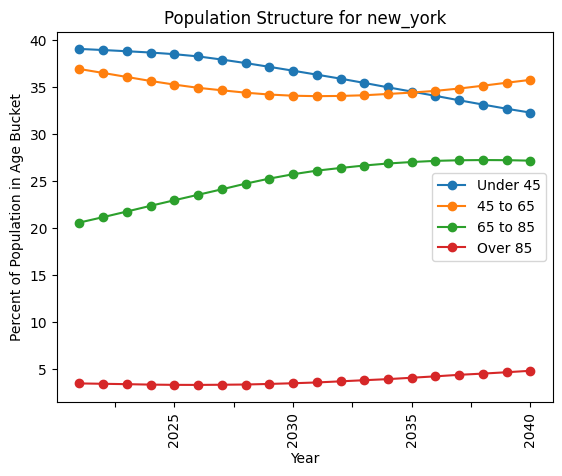

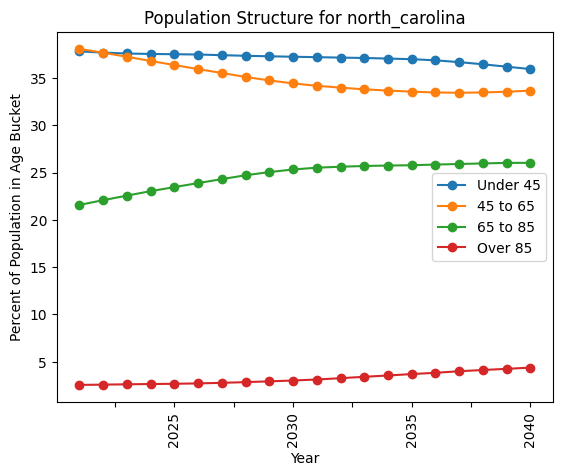

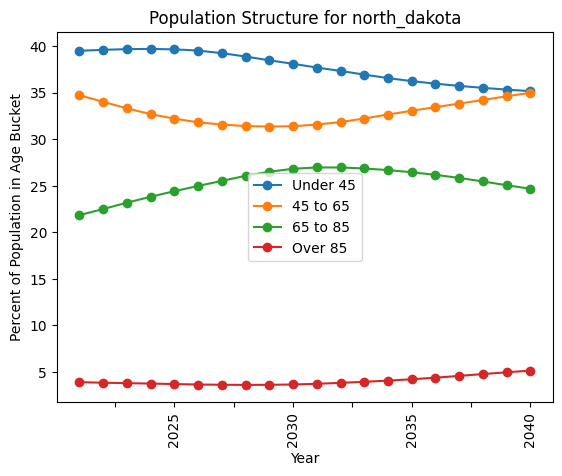

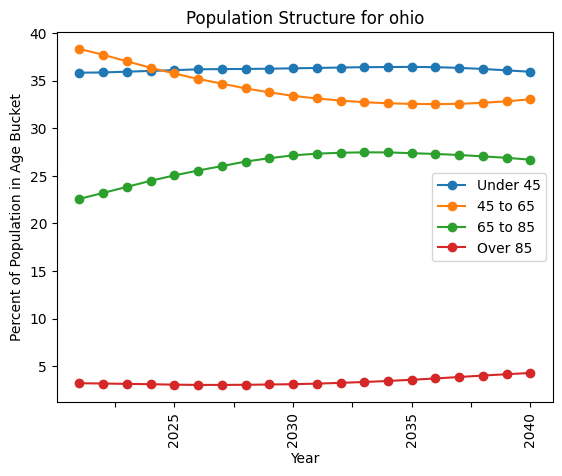

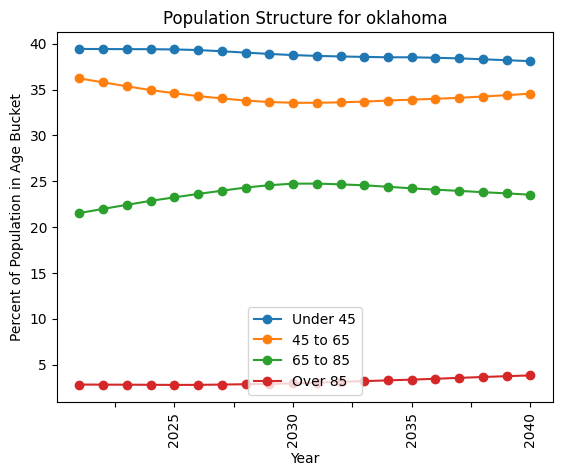

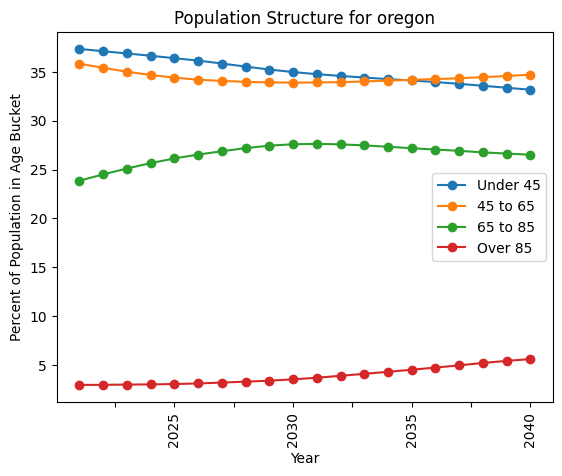

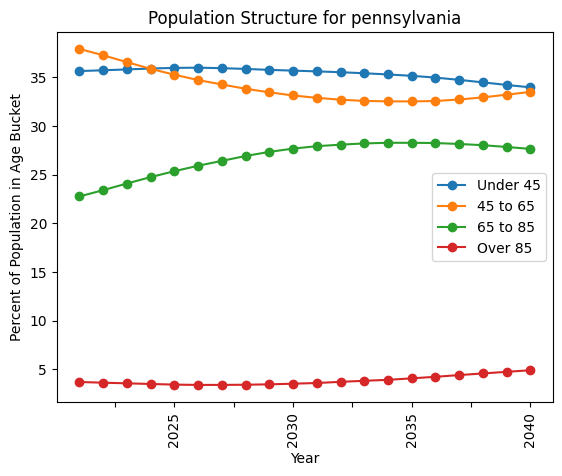

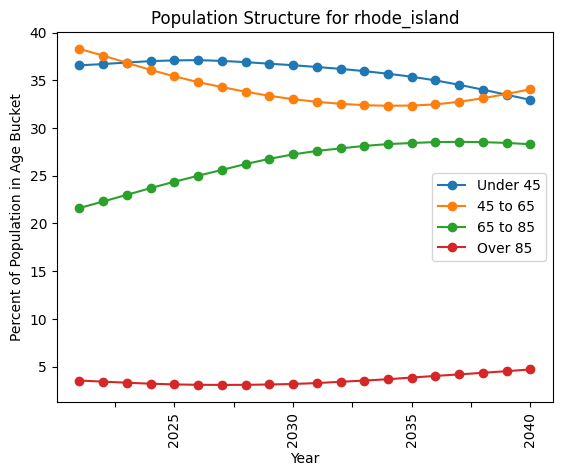

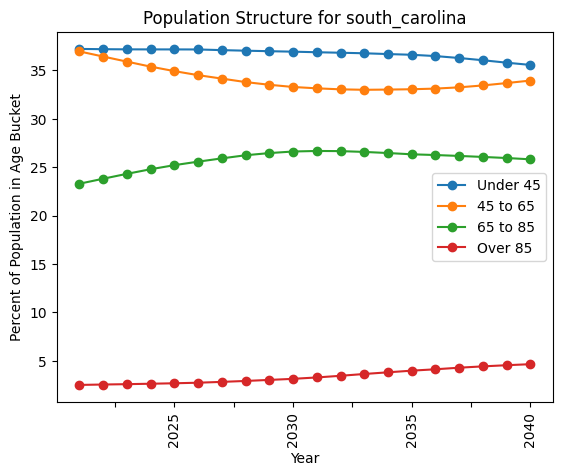

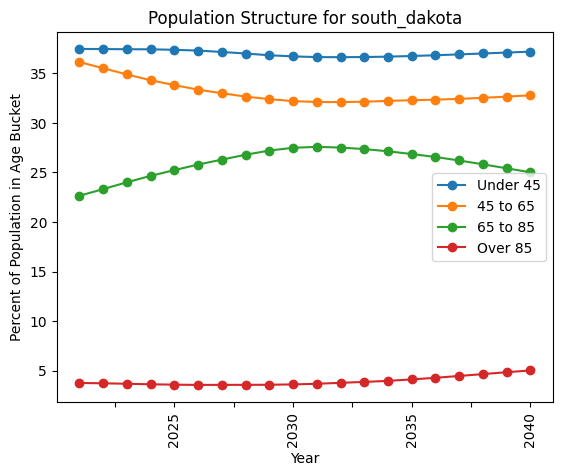

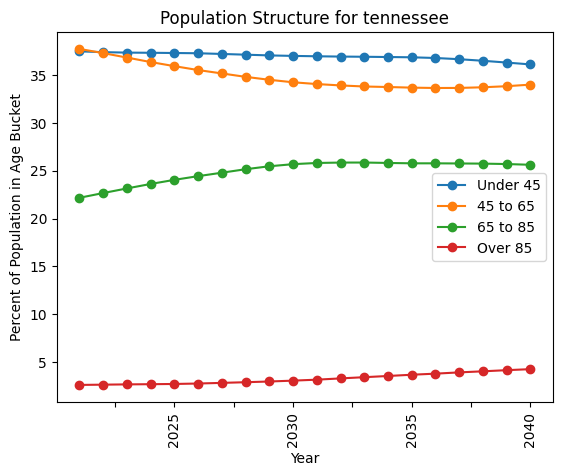

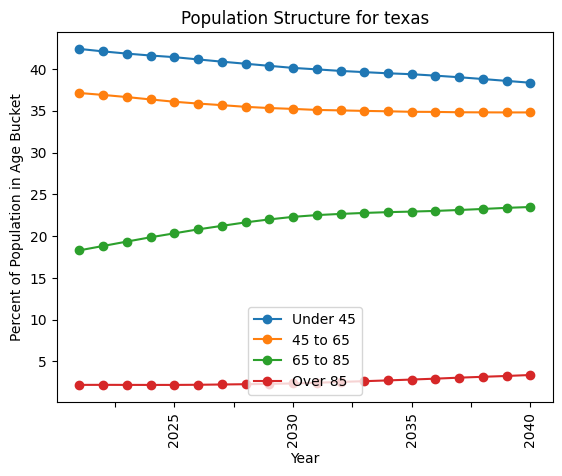

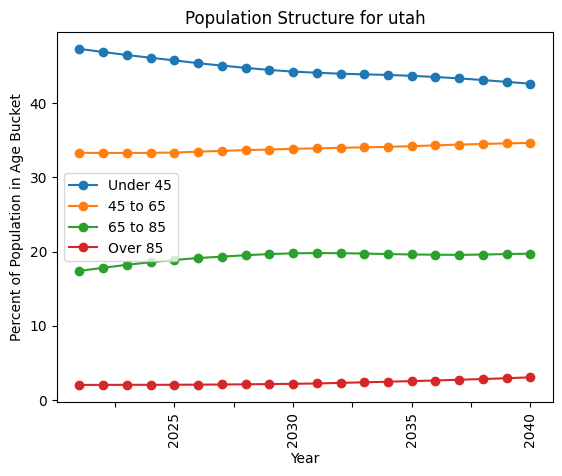

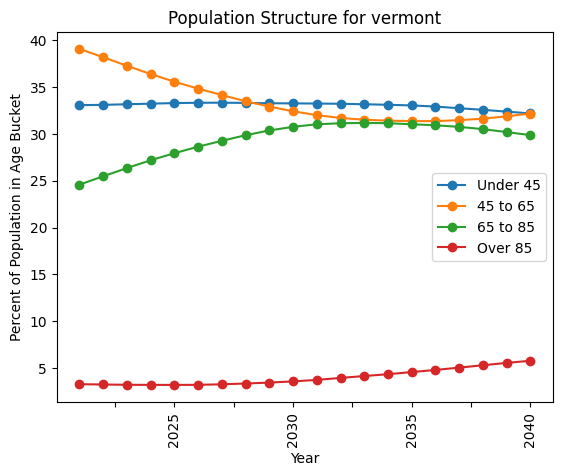

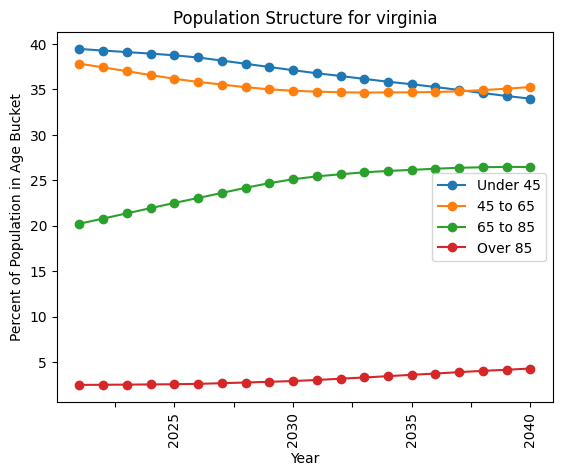

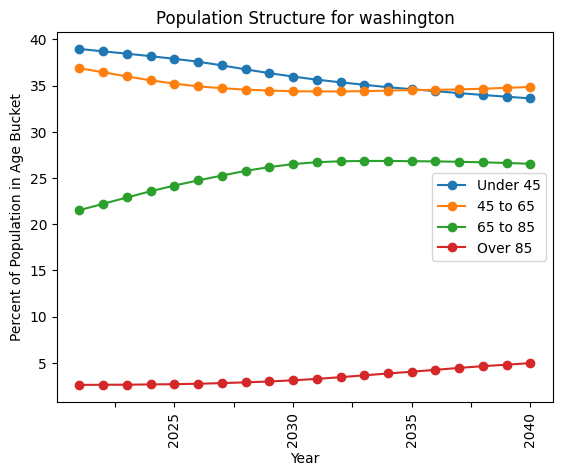

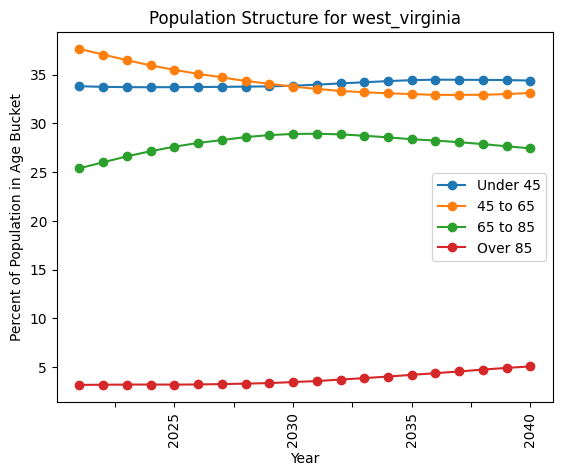

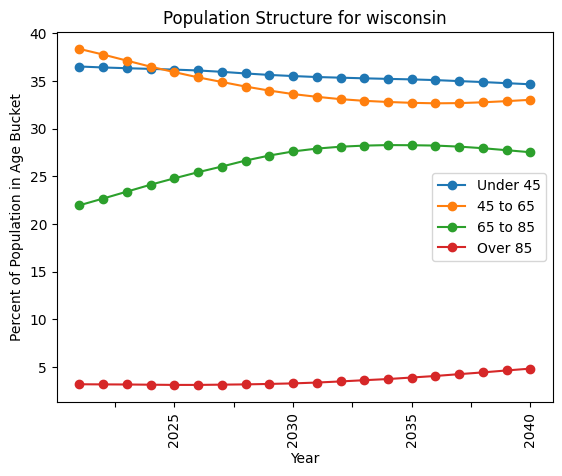

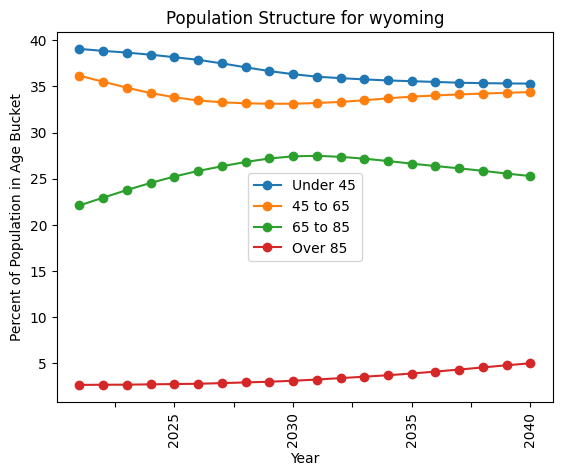

In [8]:
graph_data = percentages 
for location in graph_data.location.unique():
    plt.figure()
    subdata = graph_data.loc[(graph_data.age_bucket=='under_45') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['percent'], marker = 'o', label = 'Under 45')
    subdata = graph_data.loc[(graph_data.age_bucket=='45_to_65') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['percent'], marker = 'o', label = '45 to 65')
    subdata = graph_data.loc[(graph_data.age_bucket=='65_to_85') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['percent'], marker = 'o', label = '65 to 85')
    subdata = graph_data.loc[(graph_data.age_bucket=='over_85') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['percent'], marker = 'o', label = 'Over 85')
    plt.title(f'Population Structure for {location}')
    plt.legend()
    plt.xticks(rotation=90) 
    plt.xlabel('Year')
    plt.xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
    plt.ylabel(f'Percent of Population in Age Bucket')

# Now Look at Time on Interventions

In [9]:
sim_results_dir2 = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final-runs-test/nih_us_cvd/2023_12_18_15_45_33/count_data/'

In [10]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final-runs-test/nih_us_cvd/2023_12_18_15_45_33/count_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
deaths.csv                       state_person_time.csv
healthcare_visits.csv            transition_count.csv
intervention_person_time.csv     ylds.csv
ldlc_medication_person_time.csv  ylls.csv


In [11]:
intervention_time = pd.read_csv(sim_results_dir2 + 'intervention_person_time.csv')
intervention_time = intervention_time.loc[intervention_time.intervention == 'yes']
intervention_time = intervention_time.groupby(['year','intervention_type','location']).value.sum().reset_index()
intervention_time.head()

year intervention_type    location        value
0  2021         lifestyle     alabama  1097.155373
1  2021         lifestyle      alaska  1018.042437
2  2021         lifestyle     arizona  1089.796030
3  2021         lifestyle    arkansas  1131.192334
4  2021         lifestyle  california   949.968515

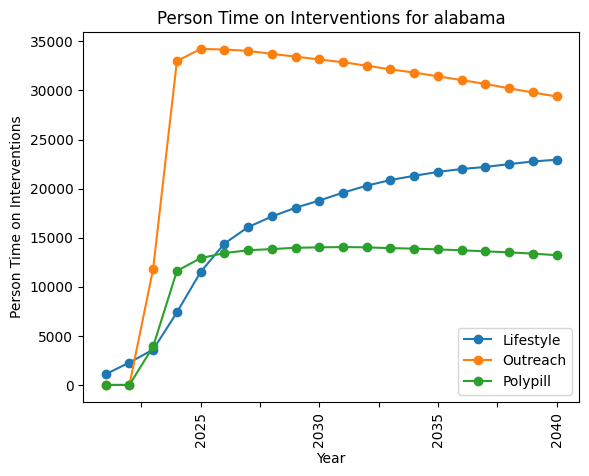

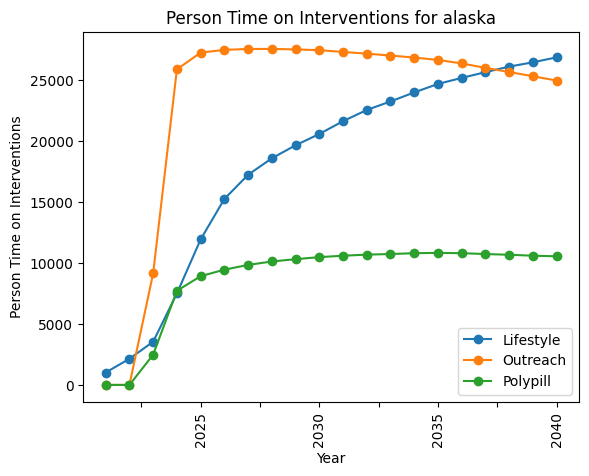

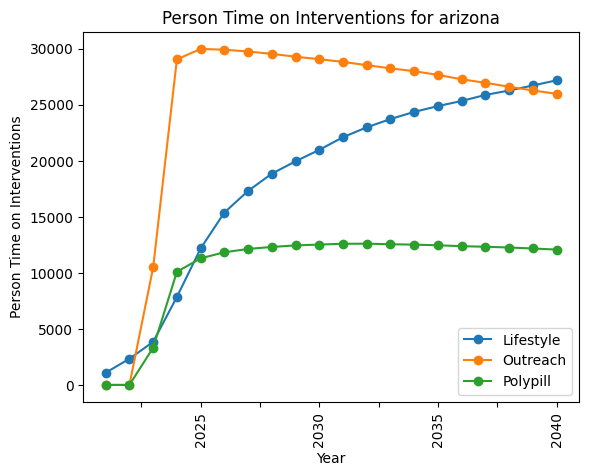

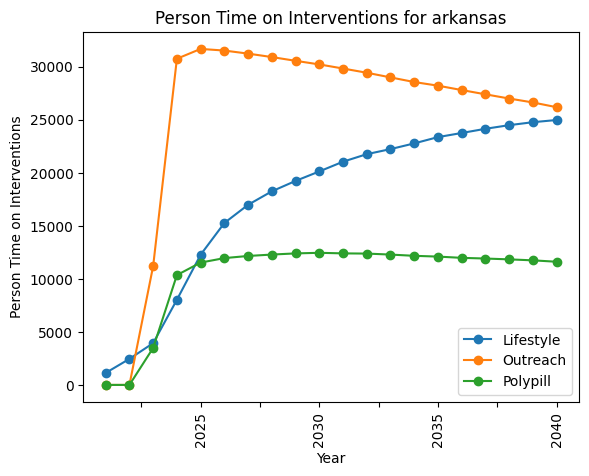

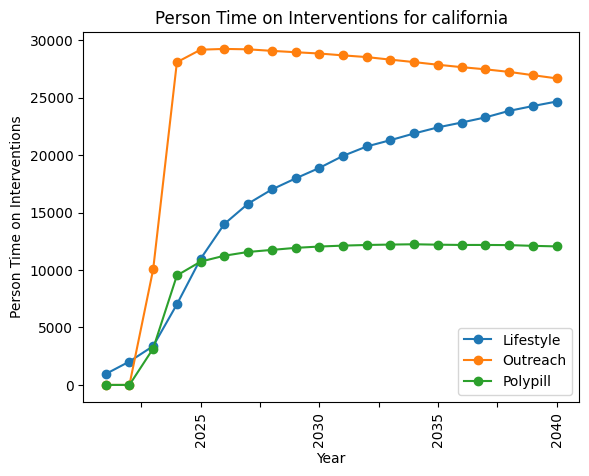

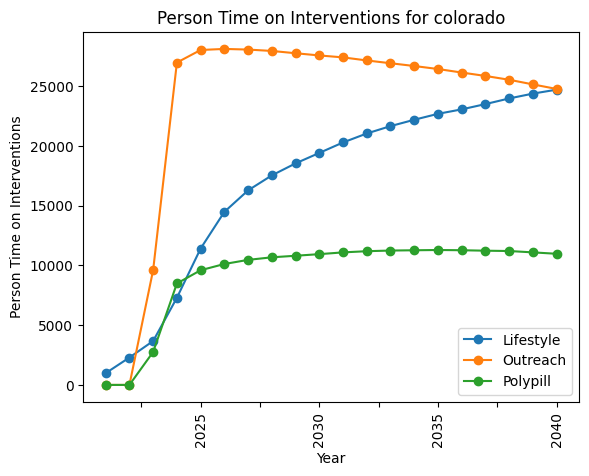

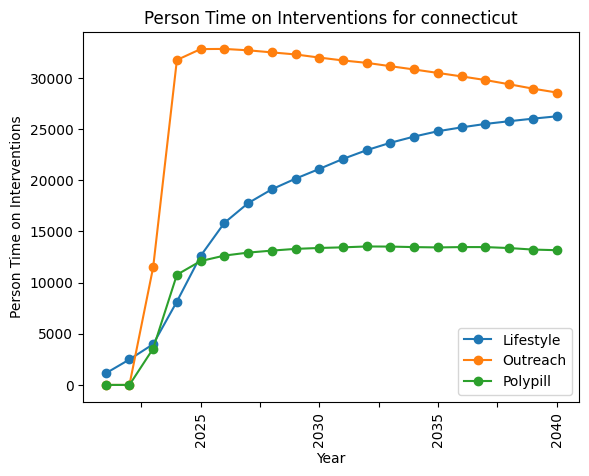

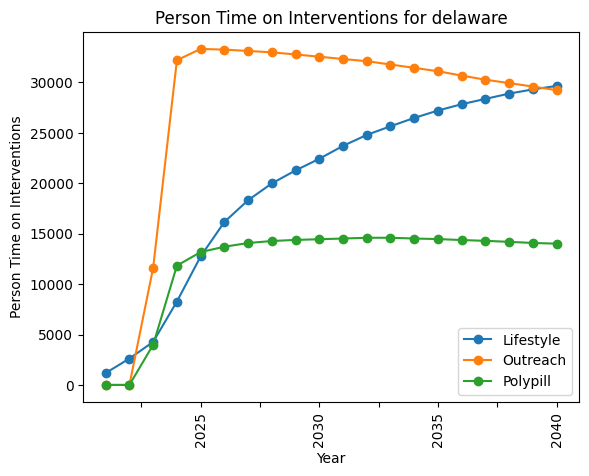

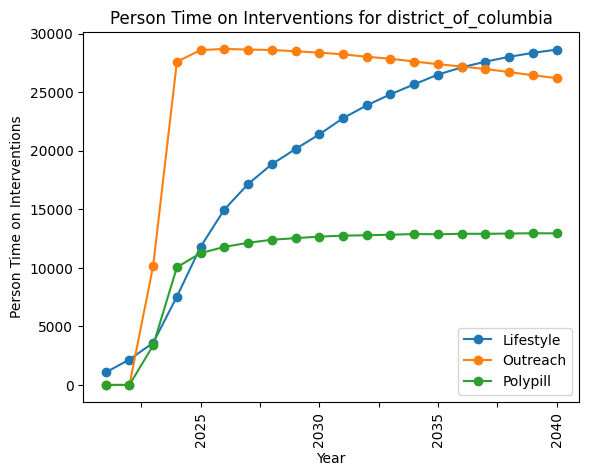

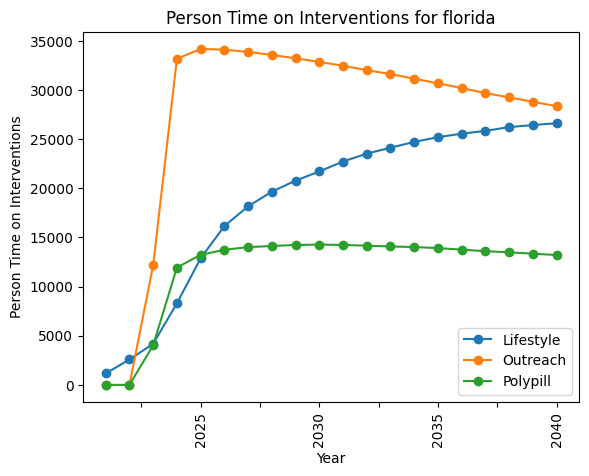

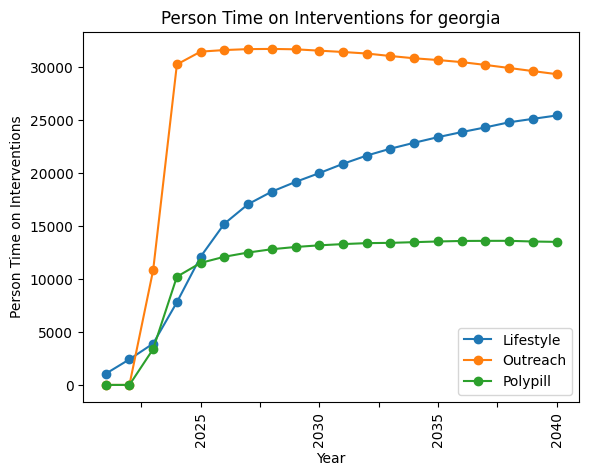

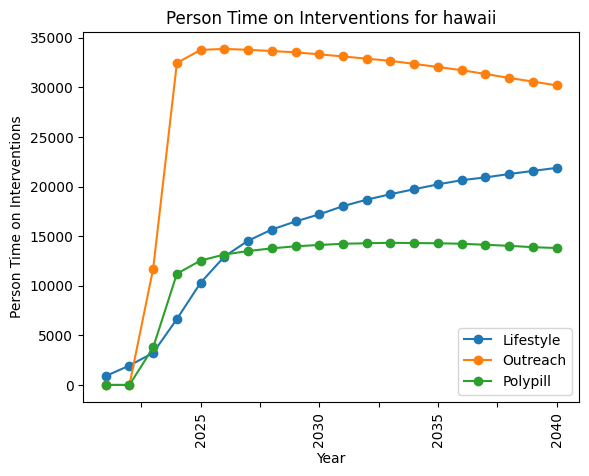

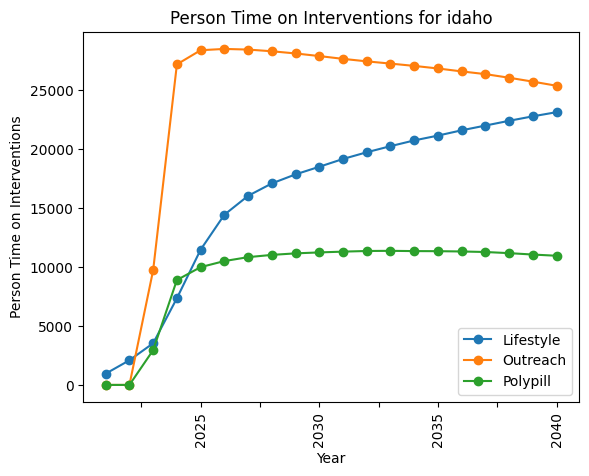

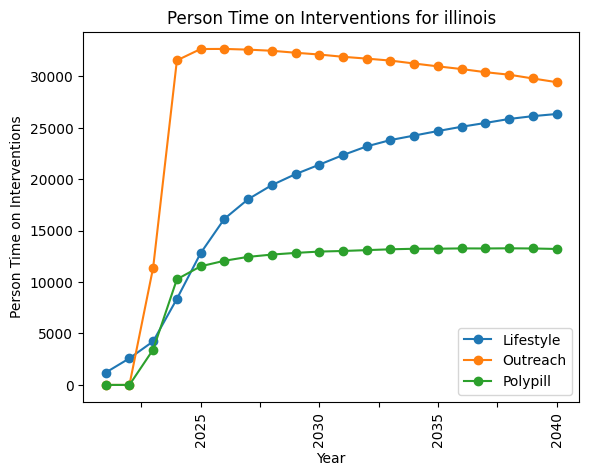

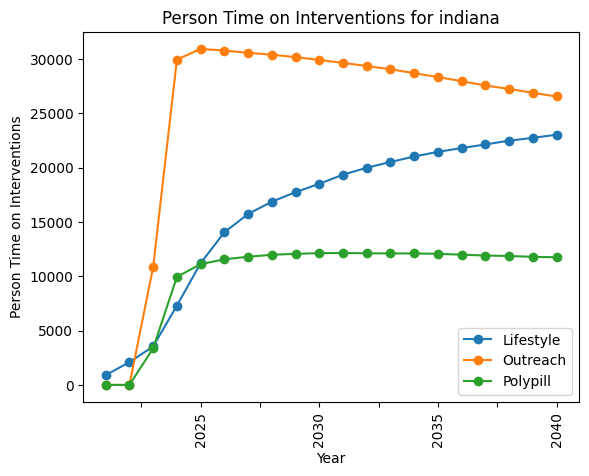

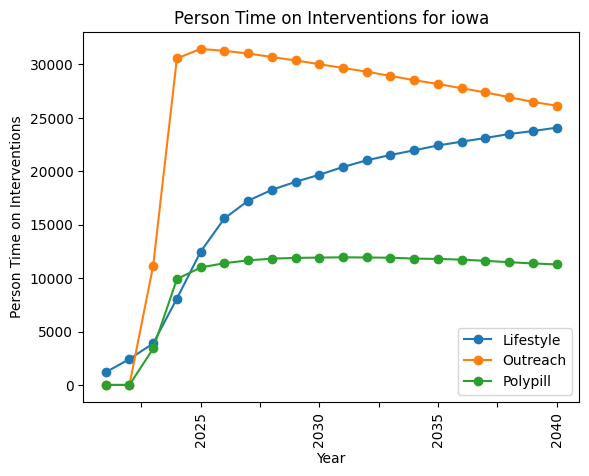

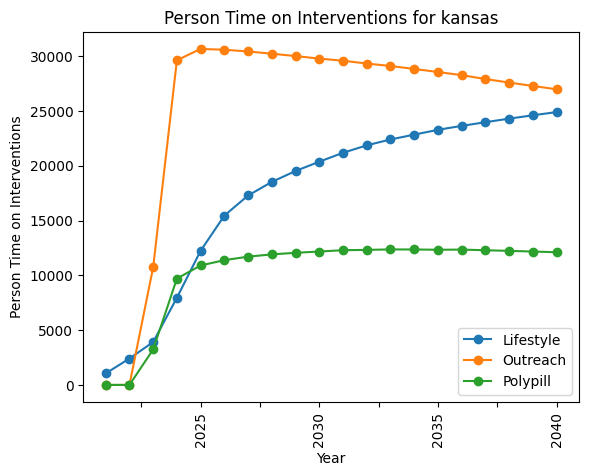

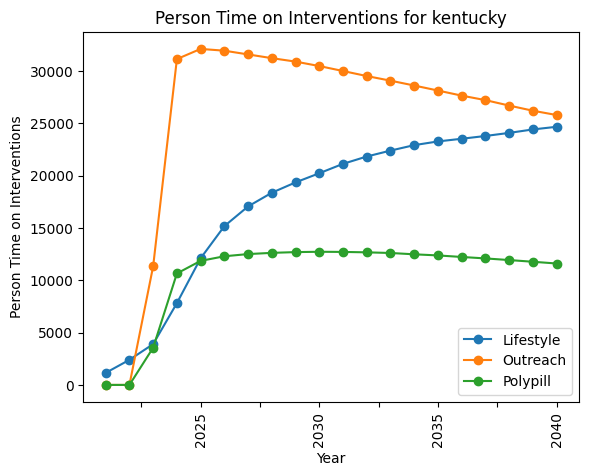

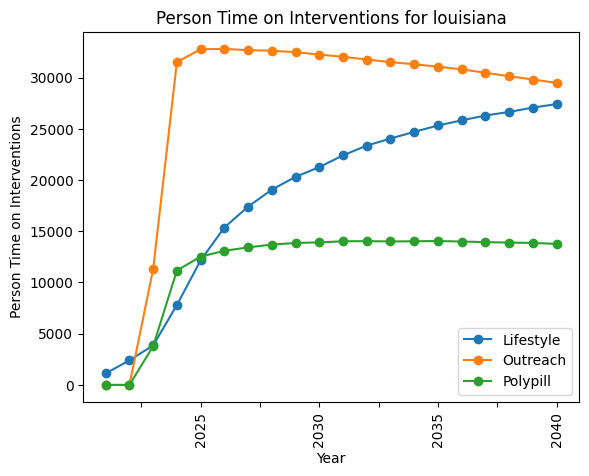

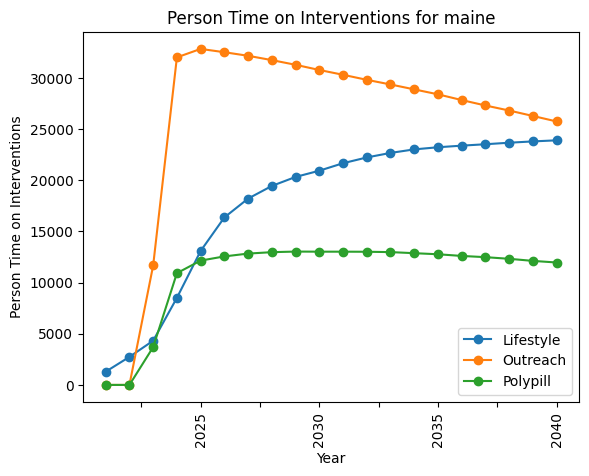

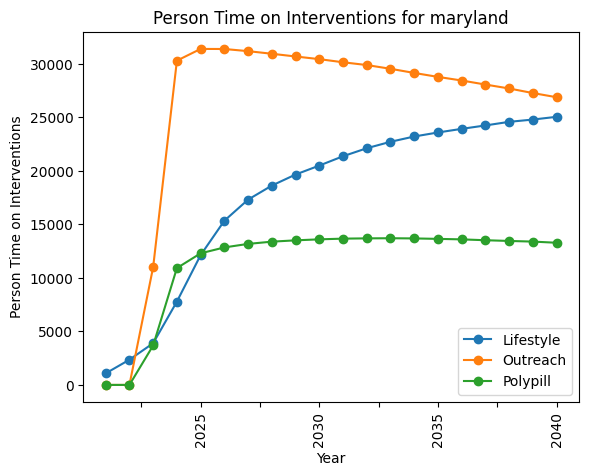

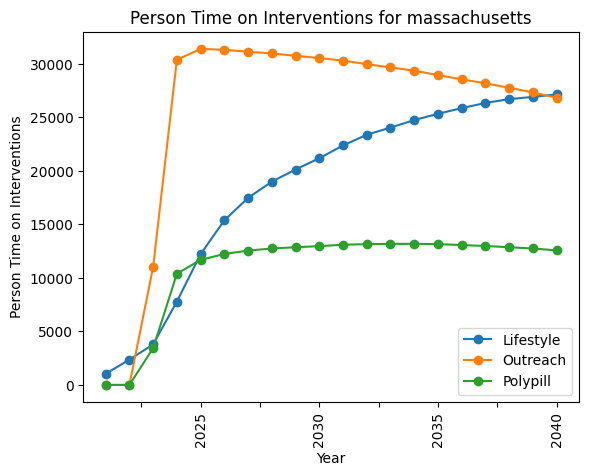

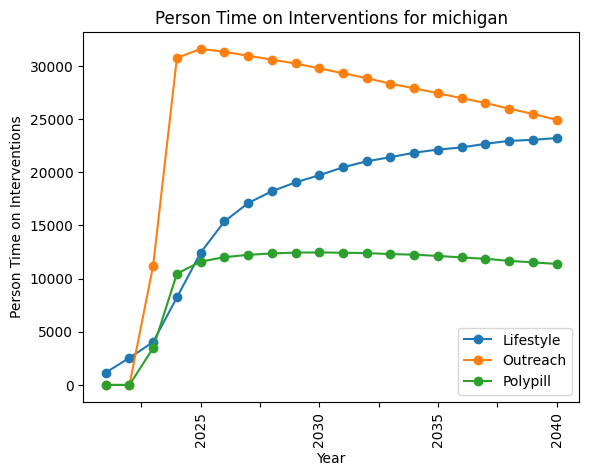

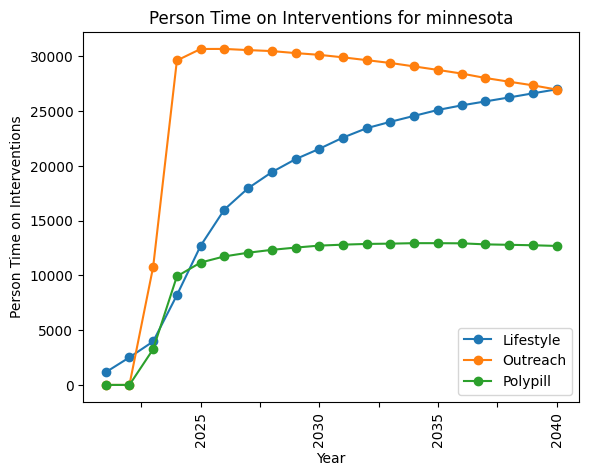

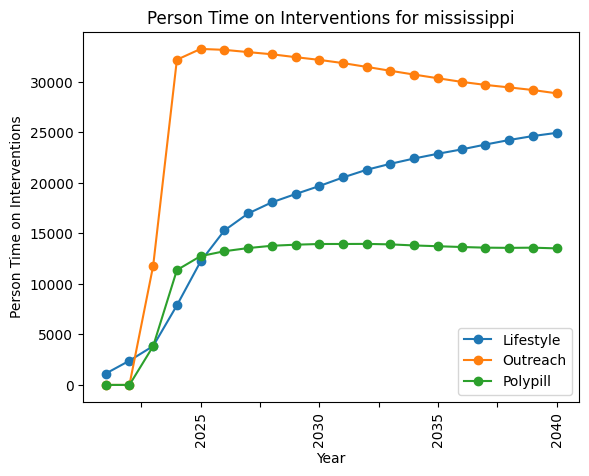

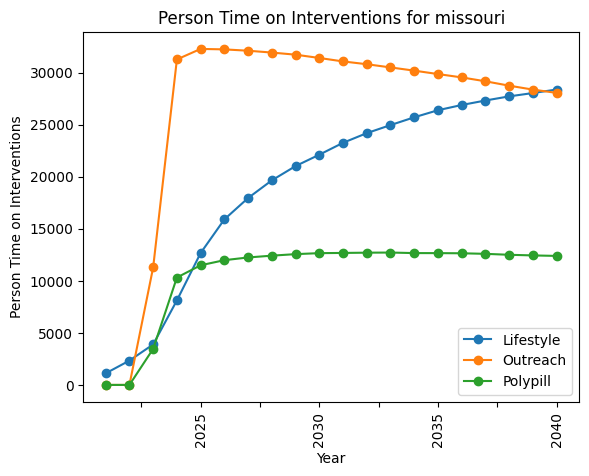

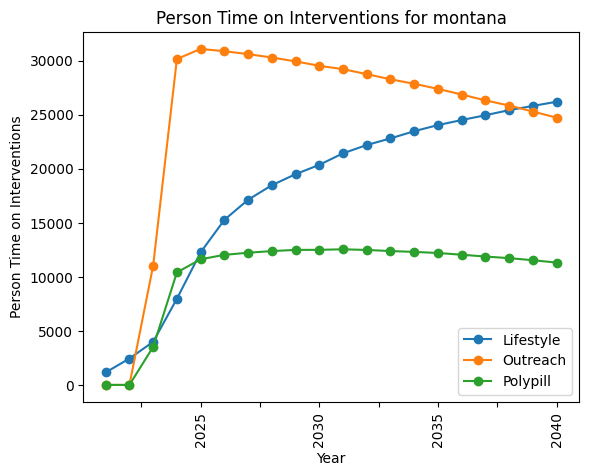

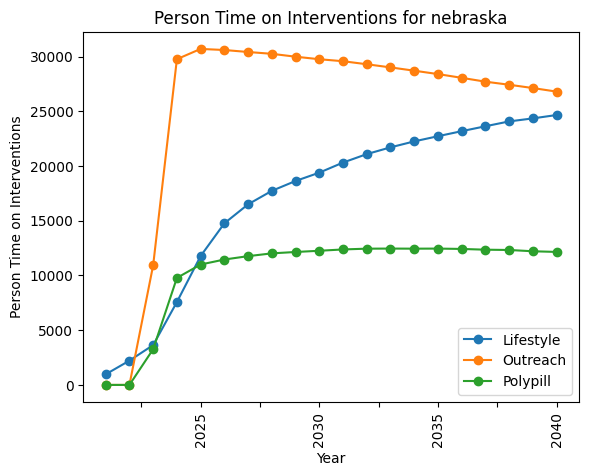

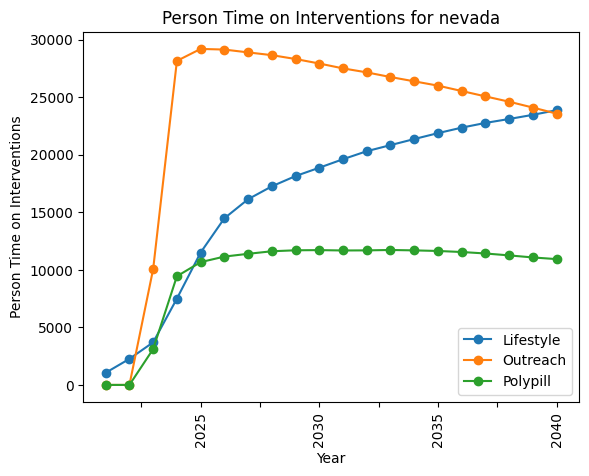

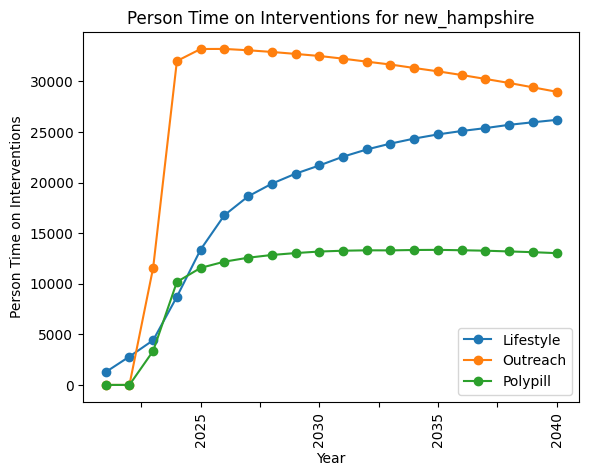

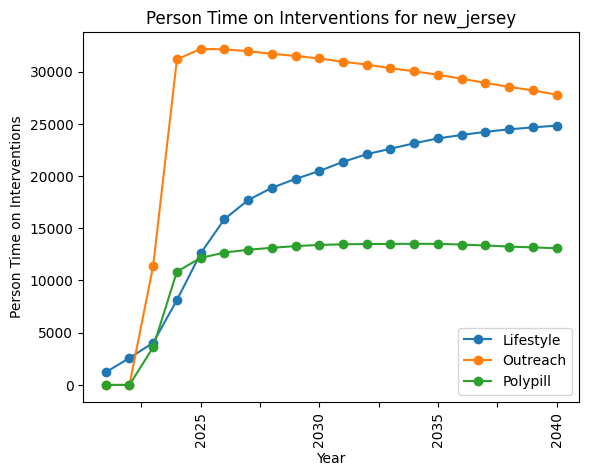

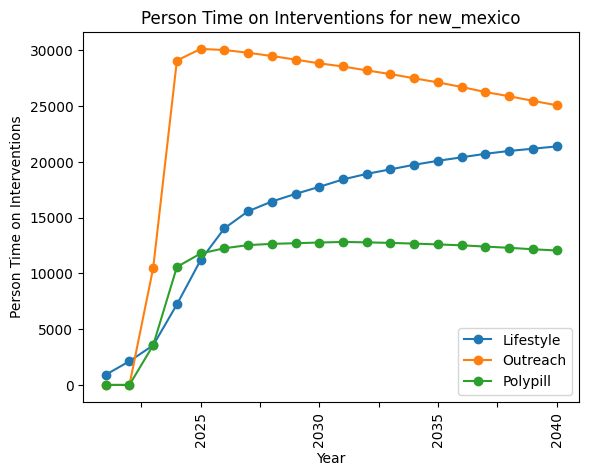

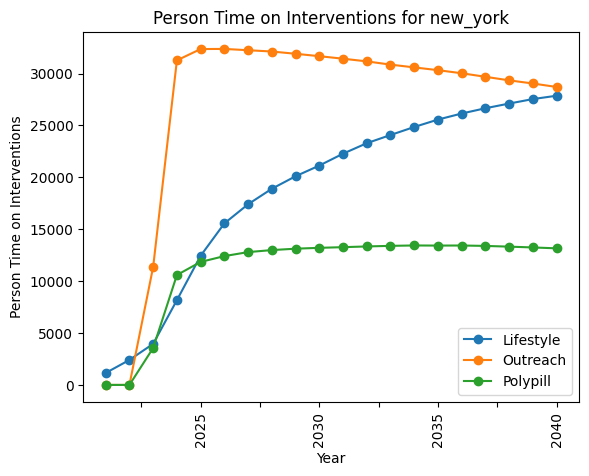

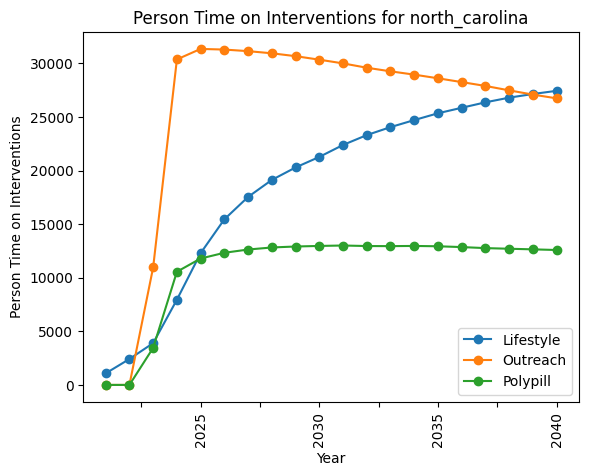

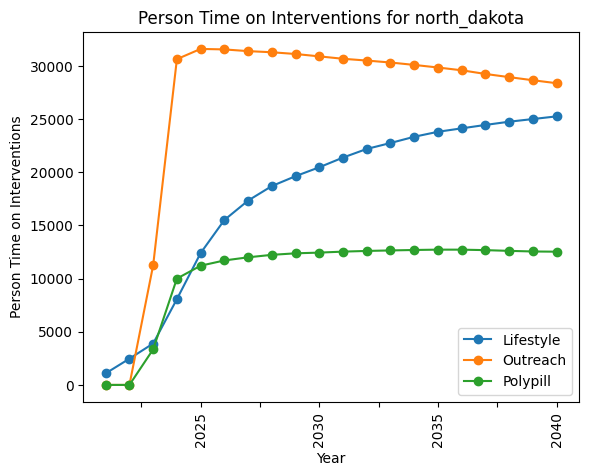

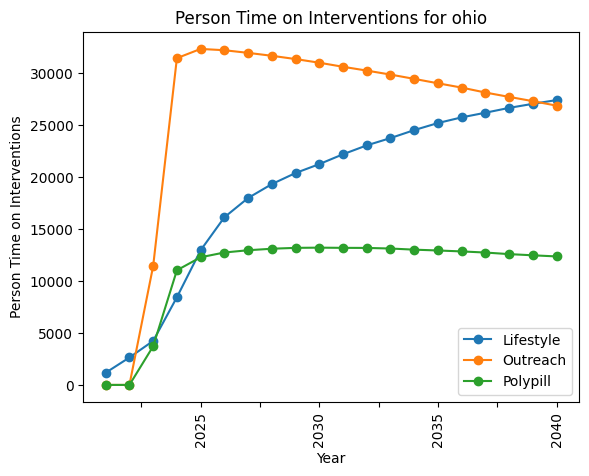

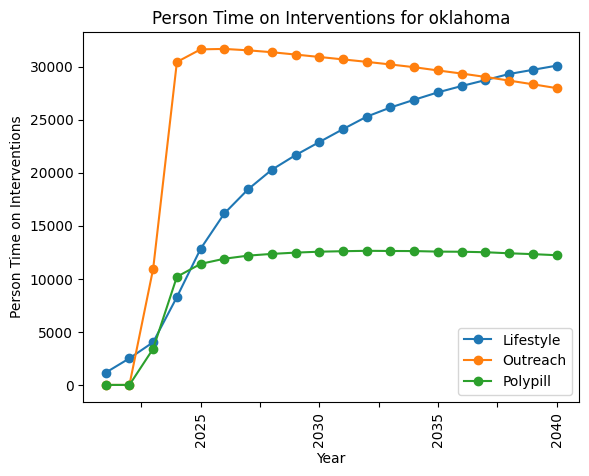

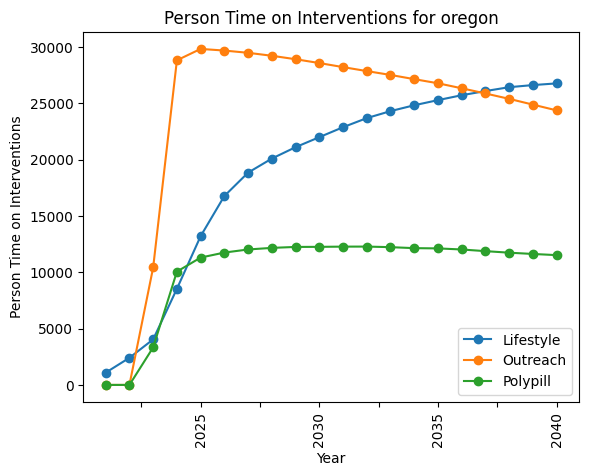

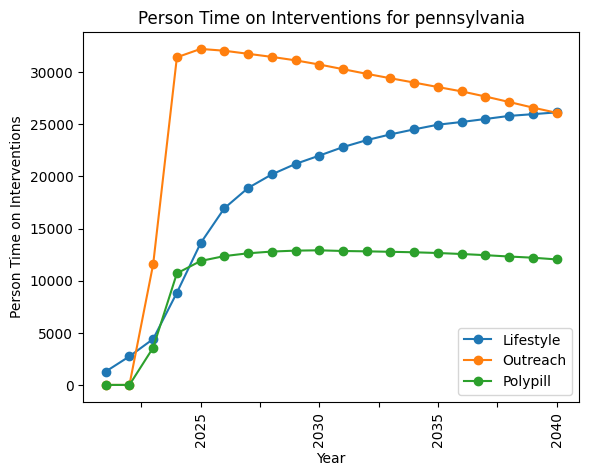

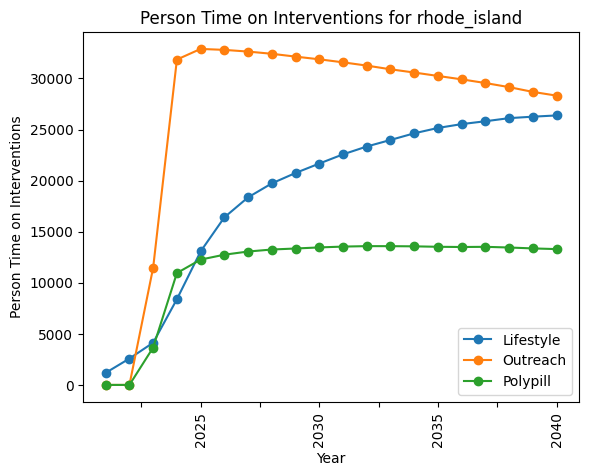

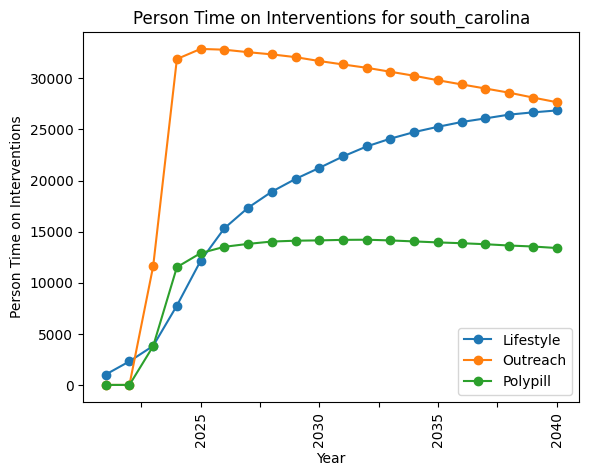

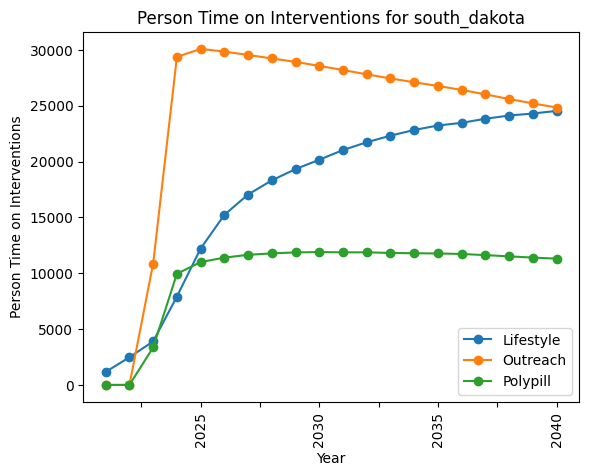

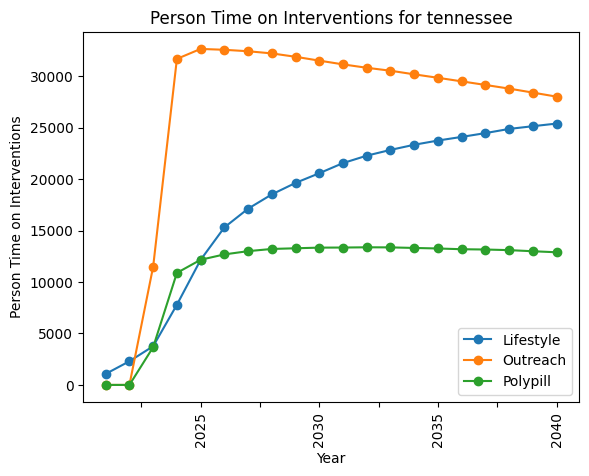

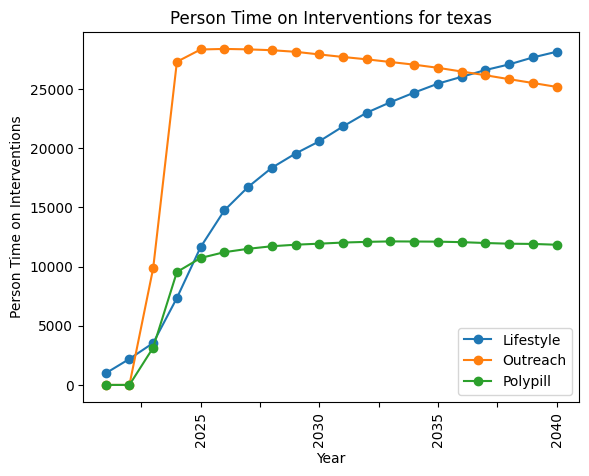

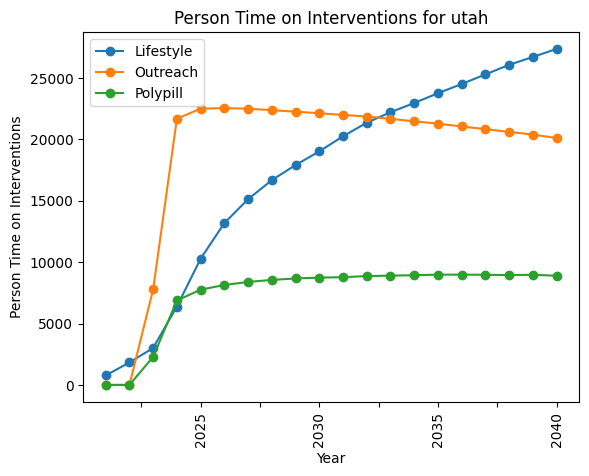

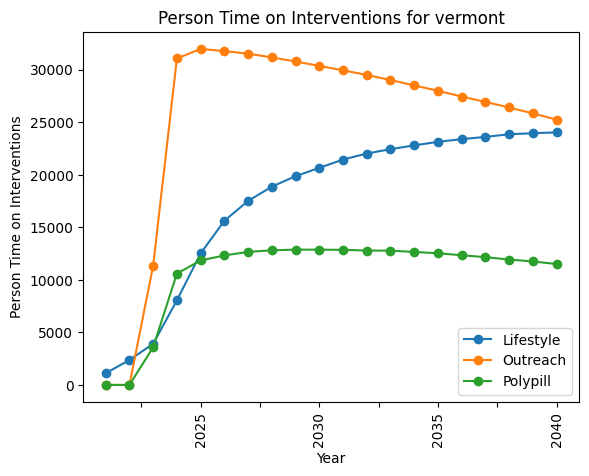

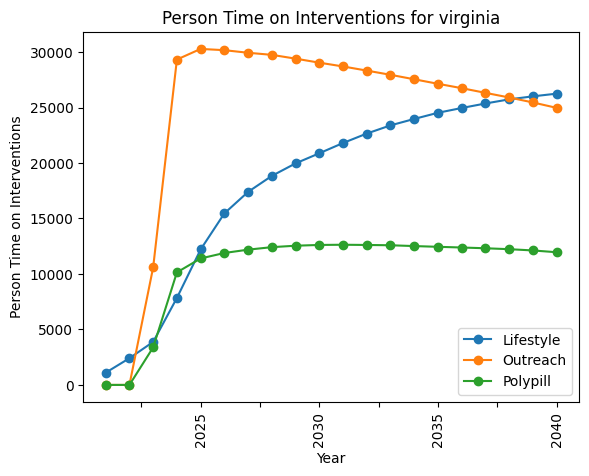

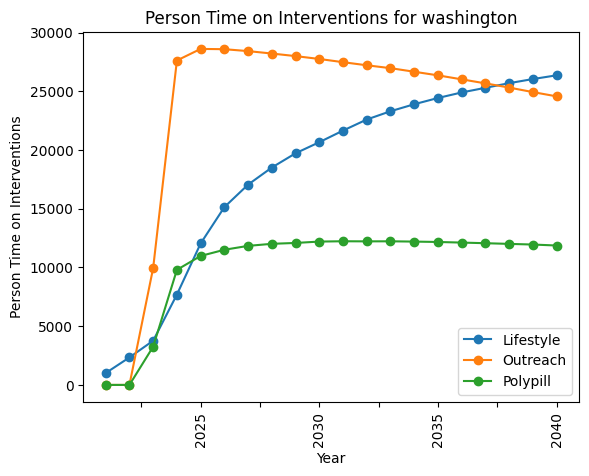

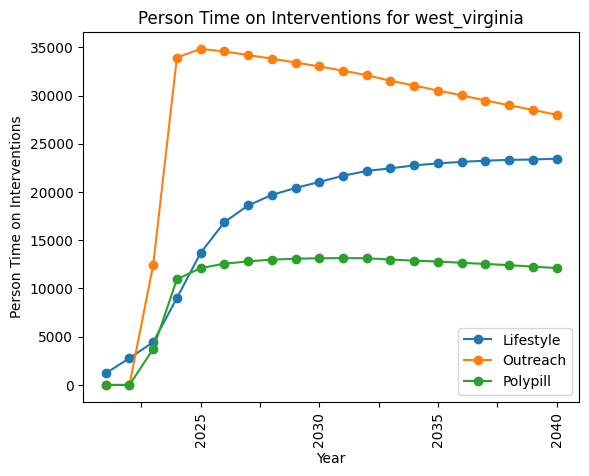

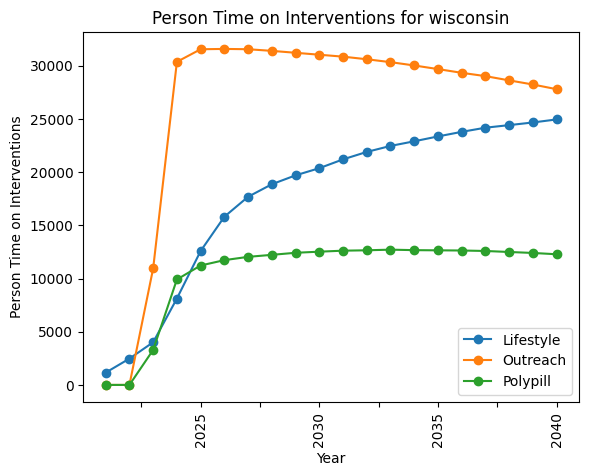

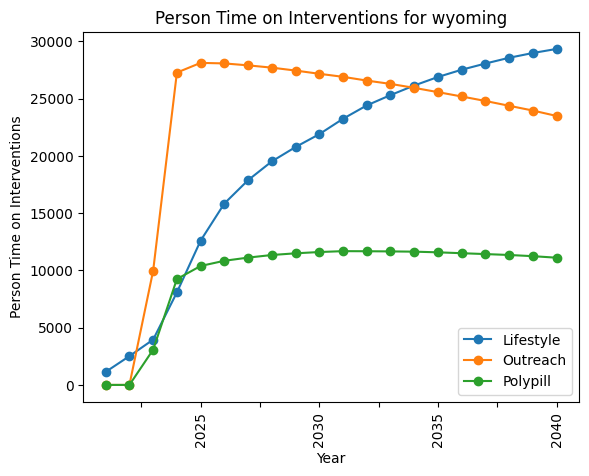

In [12]:
graph_data = intervention_time 
for location in graph_data.location.unique():
    plt.figure()
    subdata = graph_data.loc[(graph_data.intervention_type=='lifestyle') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['value'], marker = 'o', label = 'Lifestyle')
    subdata = graph_data.loc[(graph_data.intervention_type=='outreach') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['value'], marker = 'o', label = 'Outreach')
    subdata = graph_data.loc[(graph_data.intervention_type=='polypill') & (graph_data.location==location)]
    plt.plot(subdata['year'], subdata['value'], marker = 'o', label = 'Polypill')
    plt.title(f'Person Time on Interventions for {location}')
    plt.legend()
    plt.xticks(rotation=90) 
    plt.xlabel('Year')
    plt.xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
    plt.ylabel(f'Person Time on Interventions')